# VCs Characteristics exploration

## Data ETL

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import warnings
from tqdm import tqdm  # For progress bar
from networkx.algorithms.community import greedy_modularity_communities

# warnings.filterwarnings('ignore')

import sys

sys.path.append('../') 

# Import custom modules
from libs.data_cleaning import *
from libs.data_extraction import *
from libs.network_analysis import *
from libs.nestedsness_calculator import *
from libs.curveball import *

plt.style.use('default')
sns.set_palette('husl')

country = "us"
data_dir = f'../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 22,527
Investors: 38,843
Investments: 147,832
Funding rounds: 268,283


In [19]:
vc_investments = extract_vc_investments(cleaned_data['investments'])
vc_investments['investor_name'] = vc_investments[['investor_name', 'investment_type']].agg('-'.join, axis=1)

Found 104618 VC investments
Unique companies with VC funding: 16932


In [20]:
early_stages = set(['angel', 'pre_seed', 'seed', 'series_a'])
late_stages = set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i'])
min_year = 2004
max_year = 2024

early_stage_mask = vc_investments['investment_type'].isin(early_stages)
late_stage_mask = vc_investments['investment_type'].isin(late_stages)

# Create left and right
right_investments = vc_investments[
  (early_stage_mask)
]

left_investments = vc_investments[
  (late_stage_mask)
]

investments_pairs = create_investment_pairs(left_investments, right_investments, 'left', 'right')
investments_pairs['announced_year'] = investments_pairs[['announced_year_left', 'announced_year_right']].max(axis=1)
investments_pairs['year'] = investments_pairs['announced_year']
investments_pairs['total_funding_usd'] = investments_pairs['total_funding_usd_left']
investments_pairs['company_country'] = investments_pairs['company_country_left']
investments_pairs['category'] = investments_pairs['category_left']

Created 169679 investment pairs
Covering 3666 unique statups


In [21]:
investments_pairs_clean = investments_pairs[[
    'investor_name_left',
    'investor_name_right',
    'announced_year_left',
    'announced_year_right', 
    'org_uuid',
    'total_funding_usd',
    'total_funding_usd_left',
    'total_funding_usd_right',
    'year',
    'total_funding_usd',
    'company_country',
    'investor_country_left',
    'investor_country_right',
    'investment_type_left',
    'investment_type_right',
    'category_left',
    'category_right',
]].copy()

investments_pairs_clean = investments_pairs_clean.dropna(subset=['year'])
investments_pairs_clean = investments_pairs_clean[(investments_pairs_clean['year'] >= min_year) & (investments_pairs_clean['year'] <= max_year)]

# Filter out pairs where the VCs might be related (first 5 characters of names match)
investments_pairs_clean = investments_pairs_clean[
    investments_pairs_clean['investor_name_left'].str[:5] != 
    investments_pairs_clean['investor_name_right'].str[:5]
]

## Bipartite Network Analysis

### Create bipartite graph

In [23]:
bipartite_graph = create_bipartite_graph(investments_pairs_clean, 'investor_name_left', 'investor_name_right', None, 'left', 'right')
bipartite_sets = get_bipartite_sets(bipartite_graph)

set_0 = bipartite_sets['set_0']
set_1 = bipartite_sets['set_1']

### Identify communities

In [ ]:
G = bipartite_graph.copy()
max_communities = 15

cummunities = list(greedy_modularity_communities(G))
len(cummunities)

168

In [ ]:
max_top_communities = 10

top_communities = sorted(cummunities, key=lambda x: len(x), reverse=True)[:max_top_communities]
print("Top 5 investor communities by size:")
for c_idx, top_community in enumerate(top_communities):
    print(f"Community {c_idx}: {len(top_community)} investors")
    
color_map = {}
for c_idx, community in enumerate(cummunities):
    comm_size = len(community)
    for node in community:
        color_map[node] = c_idx

colors = [color_map[node] for node in G.nodes]
unique_colors = sorted(set(colors))

Top 5 investor communities by size:
Community 0: 4248 investors
Community 1: 4089 investors
Community 2: 3959 investors
Community 3: 979 investors
Community 4: 188 investors
Community 5: 155 investors
Community 6: 137 investors
Community 7: 122 investors
Community 8: 64 investors
Community 9: 64 investors


In [ ]:
PLOT_KKL = False

if PLOT_KKL:
    plt.figure(figsize=(12, 10))

    pos = nx.kamada_kawai_layout(G)
    color_map = plt.cm.Set1  # Use a color palette with distinct colors

    # Draw the graph with improved visibility
    nx.draw(G, pos, 
    node_color=colors, 
    node_size=20,  # Increased for better visibility
    width=0.2,     # Slightly thicker edges
    cmap=color_map,
    with_labels=False,
    alpha=0.8)

    # Create a legend map
    legend_elements = []
    for i, comm_idx in enumerate(unique_colors[:10]):  # Limit to top 10 for readability
        comm_size = colors.count(comm_idx)
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
            label=f'Community {comm_idx} ({comm_size} nodes)',
            markerfacecolor=color_map(comm_idx), 
            markersize=10))

    plt.legend(handles=legend_elements, loc='upper right', title='Investor Communities')
    plt.title("Clusters of investors detected via communities", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Analyse communities

#### Nestdness

In [77]:
MEASURE_NESTEDNESS = True

if MEASURE_NESTEDNESS:
    # Initialize storage for community nestedness results
    community_nestedness_results = []

    # Parameters for null model analysis
    n_iterations = 100  # Number of null models to generate
    n_iterations_cv = 10000  # Number of curveball iterations
    min_community_size = 100  # Minimum nodes required for analysis

    print(f"Analyzing nestedness for {len(top_communities)} communities...")
    print("=" * 60)

    for comm_idx, community in enumerate(top_communities):
        if len(community) < min_community_size:
            print(f"Community {comm_idx}: Skipping (only {len(community)} nodes)")
            continue
        
        try:
            # Extract subgraph for this community
            subgraph = bipartite_graph.subgraph(community)
            
            # Get bipartite sets for this community
            community_set_0 = [node for node in community if node in set_0]
            community_set_1 = [node for node in community if node in set_1]
            
            # Skip if either set is empty
            if len(community_set_0) == 0 or len(community_set_1) == 0:
                print(f"Community {comm_idx}: Skipping (empty bipartite set)")
                continue
            
            print(f"Community {comm_idx}: {len(community_set_0)} left nodes, {len(community_set_1)} right nodes")
            
            # Create adjacency matrix for this community
            left_indices = {node: i for i, node in enumerate(community_set_0)}
            right_indices = {node: j for j, node in enumerate(community_set_1)}
            
            # Initialize adjacency matrix
            community_adjacency_matrix = np.zeros((len(community_set_0), len(community_set_1)))
            
            # Fill matrix with connections within this community
            for left_node in community_set_0:
                for right_node in community_set_1:
                    if subgraph.has_edge(left_node, right_node):
                        left_idx = left_indices[left_node]
                        right_idx = right_indices[right_node]
                        community_adjacency_matrix[left_idx, right_idx] = 1
            
            # Calculate observed nestedness
            calculator = NestednessCalculator(community_adjacency_matrix)
            nestedness_score = calculator.nodf(community_adjacency_matrix)
            
            # Calculate basic network metrics
            num_edges = int(community_adjacency_matrix.sum())
            density = community_adjacency_matrix.mean()
            
            print(f"  Observed nestedness (NODF): {nestedness_score:.4f}")
            print(f"  Edges: {num_edges}, Density: {density:.4f}")
            
            # Generate null models if there are enough edges
            if num_edges < 5:
                print(f"  Skipping null model analysis (too few edges: {num_edges})")
                community_nestedness_results.append({
                    'community_id': comm_idx,
                    'community_size': len(community),
                    'left_nodes': len(community_set_0),
                    'right_nodes': len(community_set_1),
                    'num_edges': num_edges,
                    'density': density,
                    'observed_nestedness': nestedness_score,
                    'null_mean': np.nan,
                    'null_std': np.nan,
                    'z_score': np.nan,
                    'p_value': np.nan,
                    'significance': 'insufficient_data'
                })
                continue
            
            # Generate null models using curveball algorithm
            null_nestedness_scores = []
            
            print(f"  Generating {n_iterations} null models...")
            for i in tqdm(range(n_iterations), desc=f"Community {comm_idx}"):
                try:
                    # Generate null model matrix by swapping while preserving degrees
                    M = community_adjacency_matrix.copy()
                    r_hp = find_presences(M)
                    RM = curve_ball(M, r_hp, n_iterations_cv)
                    
                    null_matrix = RM.astype(community_adjacency_matrix.dtype)
                    
                    # Calculate nestedness of the null model
                    calculator_null = NestednessCalculator(null_matrix)
                    null_score = calculator_null.nodf(null_matrix)
                    null_nestedness_scores.append(null_score)
                    
                except Exception as e:
                    print(f"    Error in null model iteration {i}: {e}")
                    continue
            
            # Calculate statistical significance
            if len(null_nestedness_scores) > 0:
                null_nestedness_scores_np = np.array(null_nestedness_scores)
                mean_null = np.mean(null_nestedness_scores_np)
                std_null = np.std(null_nestedness_scores_np)
                
                if std_null > 0:
                    z_score = (nestedness_score - mean_null) / std_null
                else:
                    z_score = np.nan
                
                p_value = np.sum(null_nestedness_scores_np >= nestedness_score) / len(null_nestedness_scores_np)
                significance = 'significant' if p_value < 0.05 else 'not_significant'
                
                print(f"  Null model mean: {mean_null:.4f} ± {std_null:.4f}")
                print(f"  Z-score: {z_score:.4f}, P-value: {p_value:.4f} ({significance})")
            else:
                mean_null = std_null = z_score = p_value = np.nan
                significance = 'null_model_failed'
                print(f"  Warning: No valid null models generated")
            
            # Store results
            community_nestedness_results.append({
                'community_id': comm_idx,
                'community_size': len(community),
                'left_nodes': len(community_set_0),
                'right_nodes': len(community_set_1),
                'num_edges': num_edges,
                'density': density,
                'observed_nestedness': nestedness_score,
                'null_mean': mean_null,
                'null_std': std_null,
                'z_score': z_score,
                'p_value': p_value,
                'significance': significance,
                'null_scores': null_nestedness_scores if len(null_nestedness_scores) > 0 else []
            })
            
        except Exception as e:
            print(f"Community {comm_idx}: Error - {str(e)}")
            continue

    print(f"\nAnalyzed {len(community_nestedness_results)} communities successfully")

Analyzing nestedness for 10 communities...
Community 0: 2290 left nodes, 1958 right nodes
  Observed nestedness (NODF): 0.0283
  Edges: 28268, Density: 0.0063
  Generating 100 null models...
  Observed nestedness (NODF): 0.0283
  Edges: 28268, Density: 0.0063
  Generating 100 null models...


Community 0: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]



  Null model mean: 0.0292 ± 0.0002
  Z-score: -3.6293, P-value: 1.0000 (not_significant)
Community 1: 2570 left nodes, 1519 right nodes
  Observed nestedness (NODF): 0.0108
  Edges: 15017, Density: 0.0038
  Generating 100 null models...
  Observed nestedness (NODF): 0.0108
  Edges: 15017, Density: 0.0038
  Generating 100 null models...


Community 1: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]



  Null model mean: 0.0115 ± 0.0001
  Z-score: -7.5559, P-value: 1.0000 (not_significant)
Community 2: 2844 left nodes, 1115 right nodes
  Observed nestedness (NODF): 0.0882
  Edges: 47031, Density: 0.0148
  Generating 100 null models...
  Observed nestedness (NODF): 0.0882
  Edges: 47031, Density: 0.0148
  Generating 100 null models...


Community 2: 100%|██████████| 100/100 [00:50<00:00,  2.00it/s]



  Null model mean: 0.0847 ± 0.0007
  Z-score: 4.7684, P-value: 0.0000 (significant)
Community 3: 622 left nodes, 357 right nodes
  Observed nestedness (NODF): 0.0159
  Edges: 2671, Density: 0.0120
  Generating 100 null models...


Community 3: 100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


  Null model mean: 0.0275 ± 0.0004
  Z-score: -28.5008, P-value: 1.0000 (not_significant)
Community 4: 113 left nodes, 75 right nodes
  Observed nestedness (NODF): 0.0449
  Edges: 372, Density: 0.0439
  Generating 100 null models...


Community 4: 100%|██████████| 100/100 [00:04<00:00, 21.63it/s]


  Null model mean: 0.0778 ± 0.0021
  Z-score: -15.5940, P-value: 1.0000 (not_significant)
Community 5: 103 left nodes, 52 right nodes
  Observed nestedness (NODF): 0.0500
  Edges: 248, Density: 0.0463
  Generating 100 null models...


Community 5: 100%|██████████| 100/100 [00:04<00:00, 22.47it/s]


  Null model mean: 0.0725 ± 0.0023
  Z-score: -9.9187, P-value: 1.0000 (not_significant)
Community 6: 71 left nodes, 66 right nodes
  Observed nestedness (NODF): 0.0783
  Edges: 261, Density: 0.0557
  Generating 100 null models...


Community 6: 100%|██████████| 100/100 [00:04<00:00, 24.44it/s]


  Null model mean: 0.1017 ± 0.0039
  Z-score: -5.9408, P-value: 1.0000 (not_significant)
Community 7: 86 left nodes, 36 right nodes
  Observed nestedness (NODF): 0.0997
  Edges: 234, Density: 0.0756
  Generating 100 null models...


Community 7: 100%|██████████| 100/100 [00:05<00:00, 19.80it/s]

  Null model mean: 0.1628 ± 0.0038
  Z-score: -16.7510, P-value: 1.0000 (not_significant)
Community 8: Skipping (only 64 nodes)
Community 9: Skipping (only 64 nodes)

Analyzed 8 communities successfully


In [78]:
if MEASURE_NESTEDNESS:
    # Convert results to DataFrame for analysis
    community_nestedness_df = pd.DataFrame(community_nestedness_results)

    if len(community_nestedness_df) > 0:
        print("Community Nestedness Analysis Summary:")
        print("=" * 50)
        print(f"Total communities analyzed: {len(community_nestedness_df)}")
        print(f"Significant communities (p < 0.05): {len(community_nestedness_df[community_nestedness_df['significance'] == 'significant'])}")
        
        # Display summary statistics
        print("\nNestedness Statistics:")
        valid_results = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]
        if len(valid_results) > 0:
            print(f"Mean observed nestedness: {valid_results['observed_nestedness'].mean():.4f} ± {valid_results['observed_nestedness'].std():.4f}")
            print(f"Mean null nestedness: {valid_results['null_mean'].mean():.4f} ± {valid_results['null_mean'].std():.4f}")
            print(f"Mean Z-score: {valid_results['z_score'].mean():.4f} ± {valid_results['z_score'].std():.4f}")
    else:
        print("No communities were successfully analyzed")

Community Nestedness Analysis Summary:
Total communities analyzed: 8
Significant communities (p < 0.05): 1

Nestedness Statistics:
Mean observed nestedness: 0.0520 ± 0.0336
Mean null nestedness: 0.0710 ± 0.0490
Mean Z-score: -10.3903 ± 9.9934


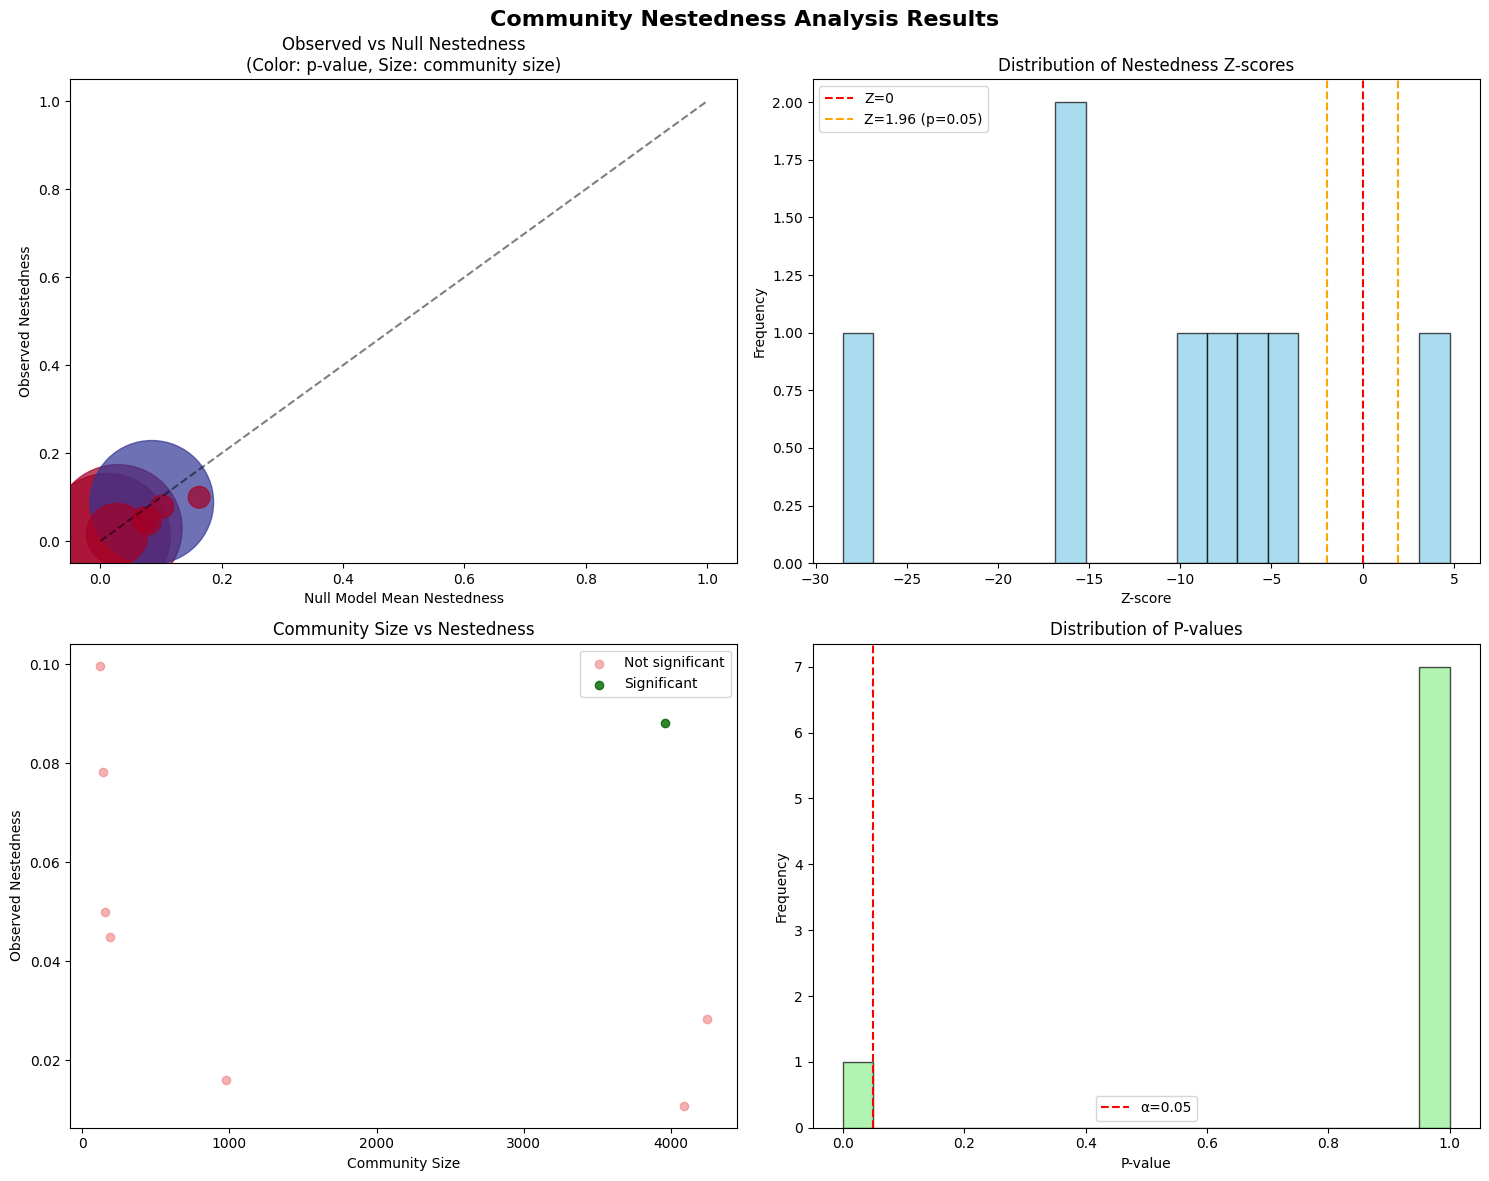


Detailed analysis for top 5 significant communities:


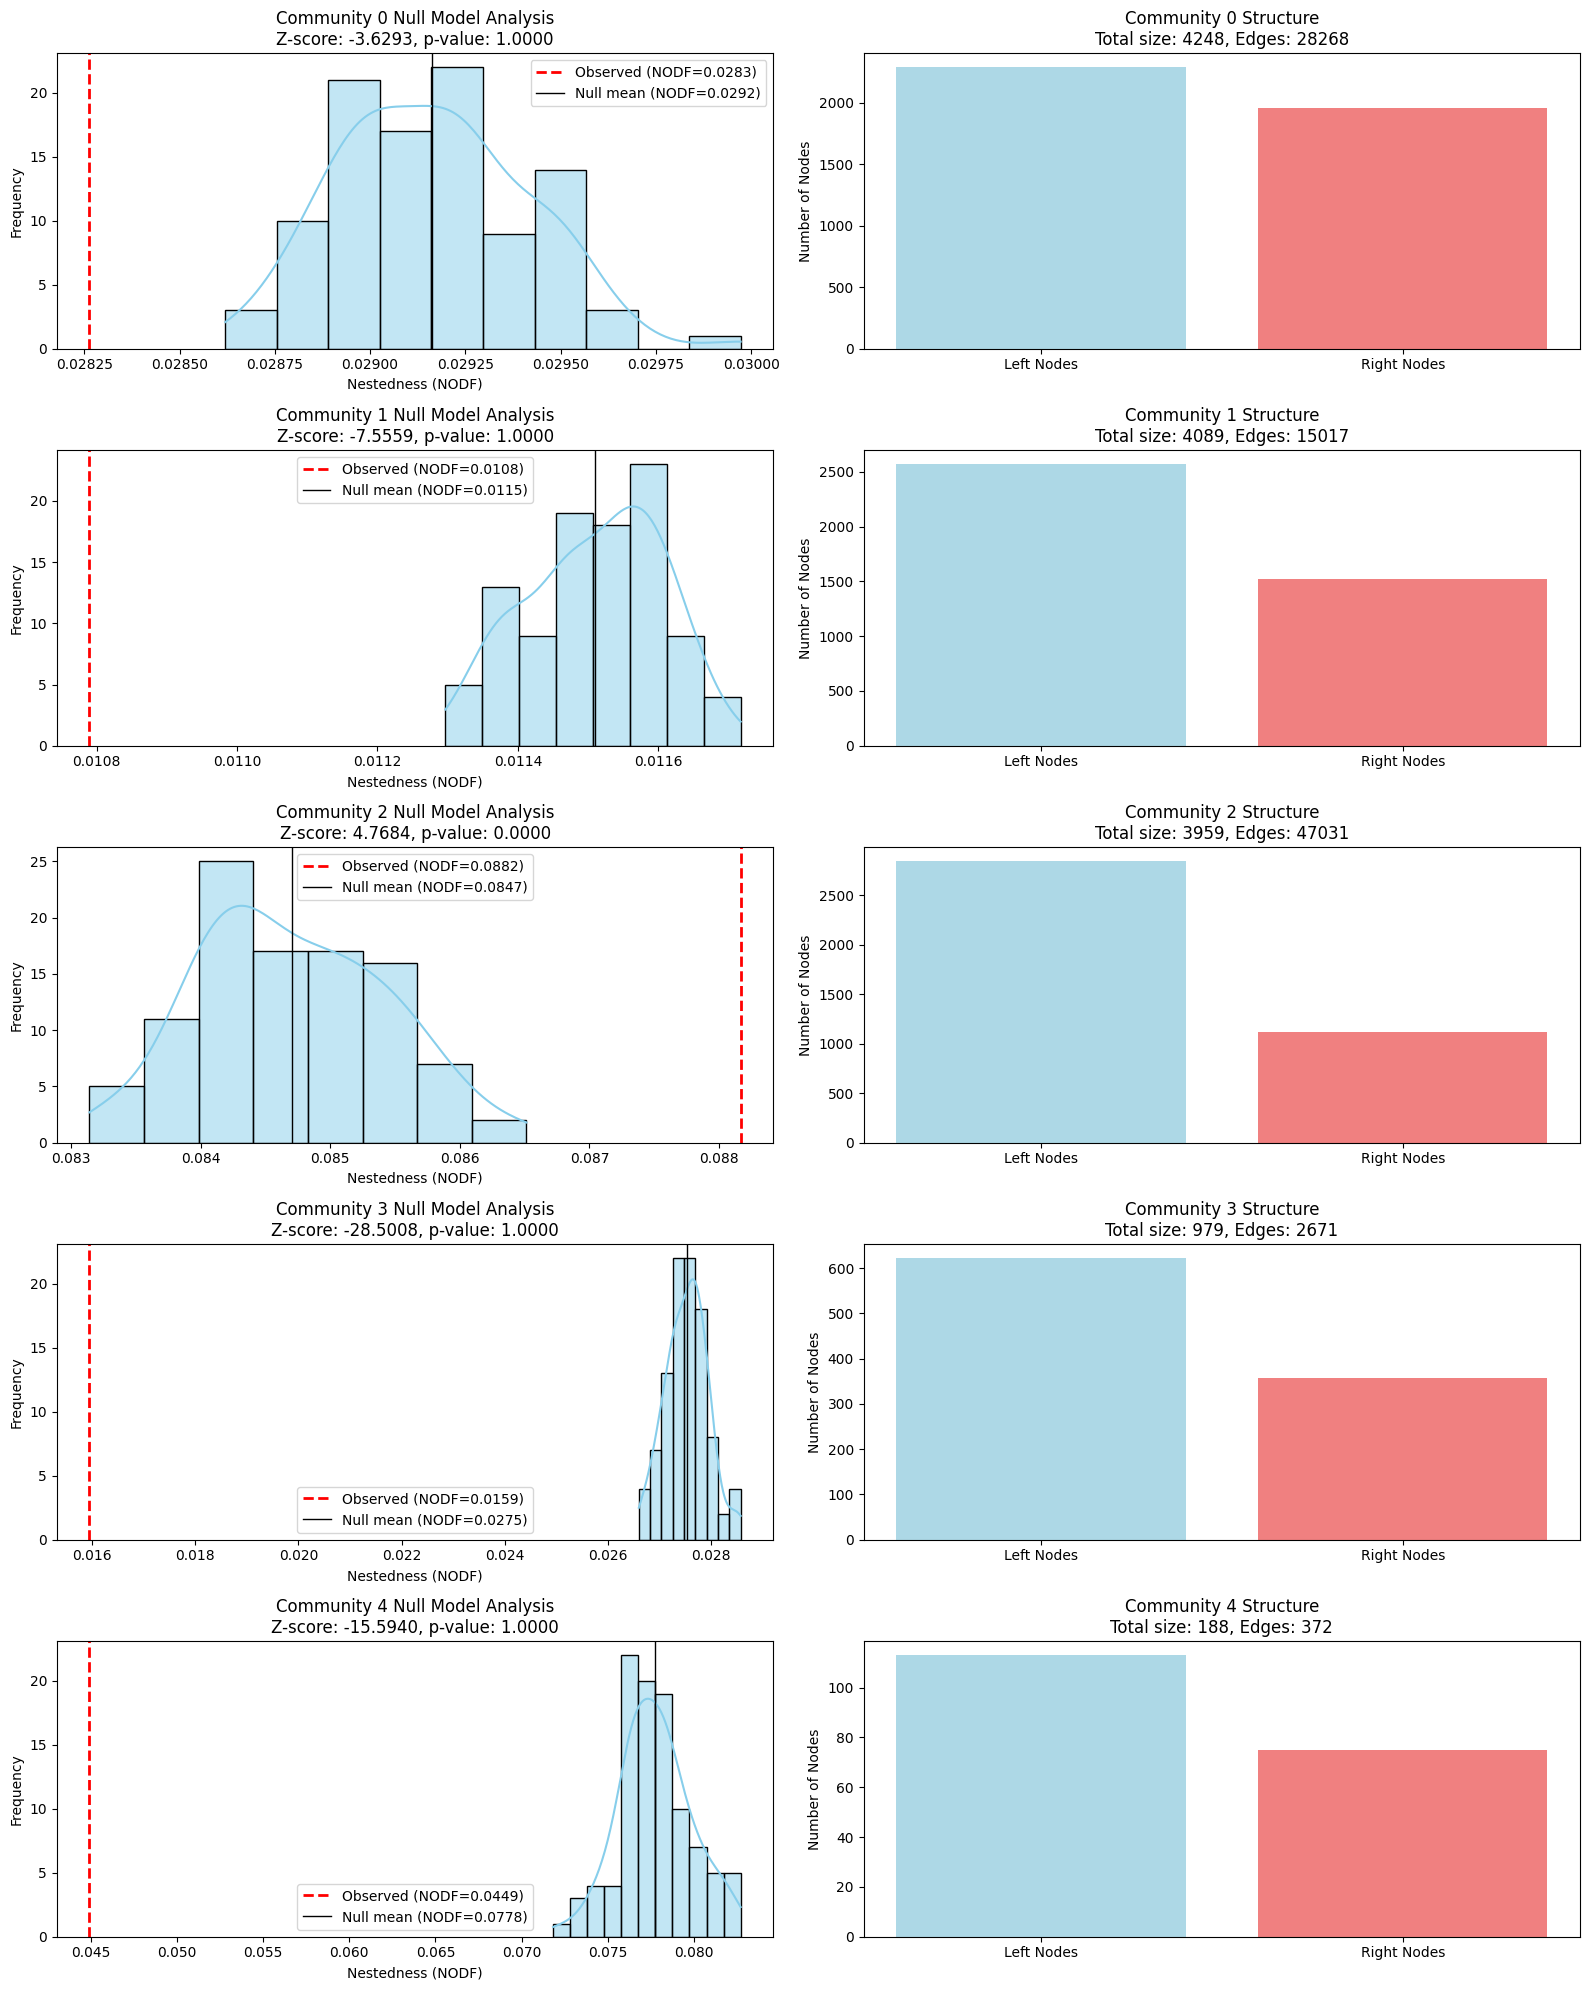

In [79]:
if MEASURE_NESTEDNESS:
    # Visualize community nestedness results
    if len(community_nestedness_df) > 0:
        valid_results = community_nestedness_df[community_nestedness_df['significance'].isin(['significant', 'not_significant'])]
        
        if len(valid_results) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle('Community Nestedness Analysis Results', fontsize=16, fontweight='bold')
            
            # Plot 1: Observed vs Null Nestedness
            axes[0, 0].scatter(valid_results['null_mean'], valid_results['observed_nestedness'], 
                            c=valid_results['p_value'], s=valid_results['community_size']*2, 
                            cmap='RdYlBu_r', alpha=0.7)
            axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
            axes[0, 0].set_xlabel('Null Model Mean Nestedness')
            axes[0, 0].set_ylabel('Observed Nestedness')
            axes[0, 0].set_title('Observed vs Null Nestedness\n(Color: p-value, Size: community size)')
            
            # Plot 2: Distribution of Z-scores
            axes[0, 1].hist(valid_results['z_score'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            axes[0, 1].axvline(0, color='red', linestyle='--', label='Z=0')
            axes[0, 1].axvline(1.96, color='orange', linestyle='--', label='Z=1.96 (p=0.05)')
            axes[0, 1].axvline(-1.96, color='orange', linestyle='--')
            axes[0, 1].set_xlabel('Z-score')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].set_title('Distribution of Nestedness Z-scores')
            axes[0, 1].legend()
            
            # Plot 3: Community size vs Nestedness
            significant_mask = valid_results['significance'] == 'significant'
            axes[1, 0].scatter(valid_results[~significant_mask]['community_size'], 
                            valid_results[~significant_mask]['observed_nestedness'],
                            c='lightcoral', alpha=0.6, label='Not significant')
            axes[1, 0].scatter(valid_results[significant_mask]['community_size'], 
                            valid_results[significant_mask]['observed_nestedness'],
                            c='darkgreen', alpha=0.8, label='Significant')
            axes[1, 0].set_xlabel('Community Size')
            axes[1, 0].set_ylabel('Observed Nestedness')
            axes[1, 0].set_title('Community Size vs Nestedness')
            axes[1, 0].legend()
            
            # Plot 4: P-value distribution
            axes[1, 1].hist(valid_results['p_value'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
            axes[1, 1].axvline(0.05, color='red', linestyle='--', label='α=0.05')
            axes[1, 1].set_xlabel('P-value')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].set_title('Distribution of P-values')
            axes[1, 1].legend()
            
            plt.tight_layout()
            plt.show()
            
            # Create detailed plots for significant communities
            significant_communities = valid_results.head(5)
            
            if len(significant_communities) > 0:
                print(f"\nDetailed analysis for top {len(significant_communities)} significant communities:")
                fig, axes = plt.subplots(len(significant_communities), 2, 
                                    figsize=(16, 4*len(significant_communities)))
                if len(significant_communities) == 1:
                    axes = axes.reshape(1, -1)
                
                for i, (_, row) in enumerate(significant_communities.iterrows()):
                    comm_idx = row['community_id']
                    null_scores = row['null_scores']
                    
                    if len(null_scores) > 0:
                        # Histogram of null model distribution
                        sns.histplot(null_scores, kde=True, color='skyblue', ax=axes[i, 0])
                        axes[i, 0].axvline(row['observed_nestedness'], color='red', linestyle='--', 
                                        linewidth=2, label=f'Observed (NODF={row["observed_nestedness"]:.4f})')
                        axes[i, 0].axvline(row['null_mean'], color='black', linestyle='-', 
                                        linewidth=1, label=f'Null mean (NODF={row["null_mean"]:.4f})')
                        axes[i, 0].set_title(f'Community {comm_idx} Null Model Analysis\n'
                                            f'Z-score: {row["z_score"]:.4f}, p-value: {row["p_value"]:.4f}')
                        axes[i, 0].set_xlabel('Nestedness (NODF)')
                        axes[i, 0].set_ylabel('Frequency')
                        axes[i, 0].legend()
                    
                    # Bar plot of community structure
                    axes[i, 1].bar(['Left Nodes', 'Right Nodes'], 
                                [row['left_nodes'], row['right_nodes']], 
                                color=['lightblue', 'lightcoral'])
                    axes[i, 1].set_title(f'Community {comm_idx} Structure\n'
                                        f'Total size: {row["community_size"]}, Edges: {row["num_edges"]}')
                    axes[i, 1].set_ylabel('Number of Nodes')
                
                plt.tight_layout()
                plt.show()
        else:
            print("No valid results available for visualization")
    else:
        print("No data available for visualization")

### Deepdive Communities

In [ ]:
investments_pairs_communities = investments_pairs.copy()
# Create a mapping from investor name to community ID
investor_to_community = {}
for comm_idx, community in enumerate(cummunities):
  for investor in community:
    investor_to_community[investor] = comm_idx

# Add community column for left and right investors
investments_pairs_communities['community_left'] = investments_pairs_communities['investor_name_left'].map(investor_to_community).fillna(-1).astype(int)
investments_pairs_communities['community_right'] = investments_pairs_communities['investor_name_right'].map(investor_to_community).fillna(-1).astype(int)

# A pair is considered to be in a community if both investors are in the same community
investments_pairs_communities['community'] = np.where(
  (investments_pairs_communities['community_left'] == investments_pairs_communities['community_right']) & 
  (investments_pairs_communities['community_left'] != -1),
  investments_pairs_communities['community_left'],
  -1
)

# Drop the intermediate columns
#investments_pairs_communities.drop(columns=['community_left', 'community_right'], inplace=True)

# Print distribution of communities
community_counts = investments_pairs_communities['community'].value_counts()
print(f"Investment pairs assigned to communities: {(investments_pairs_communities['community'] != -1).sum()}")
print(f"Investment pairs not in any community: {(investments_pairs_communities['community'] == -1).sum()}")
print("\nTop 5 communities by number of investment pairs:")
print(community_counts.head())


Investment pairs assigned to communities: 111350
Investment pairs not in any community: 58329

Top 5 communities by number of investment pairs:
community
-1    58329
 2    55863
 0    32164
 1    17301
 3     2904
Name: count, dtype: int64


In [49]:
# Filter the data for communities 0, 1, and 2
communities_of_interest = [0, 1, 2]

community_data = {}
for comm_id in communities_of_interest:
  community_data[comm_id] = investments_pairs_communities[investments_pairs_communities['community'] == comm_id]

# Print the sizes of each community
for comm_id in communities_of_interest:
  print(f"Community {comm_id}: {len(community_data[comm_id])} investment pairs")

# Function to truncate long category names
def truncate_name(name, max_length=30):
  if isinstance(name, str) and len(name) > max_length:
    return name[:max_length] + '...'
  return name

Community 0: 32164 investment pairs
Community 1: 17301 investment pairs
Community 2: 55863 investment pairs


#### Numeric Columns

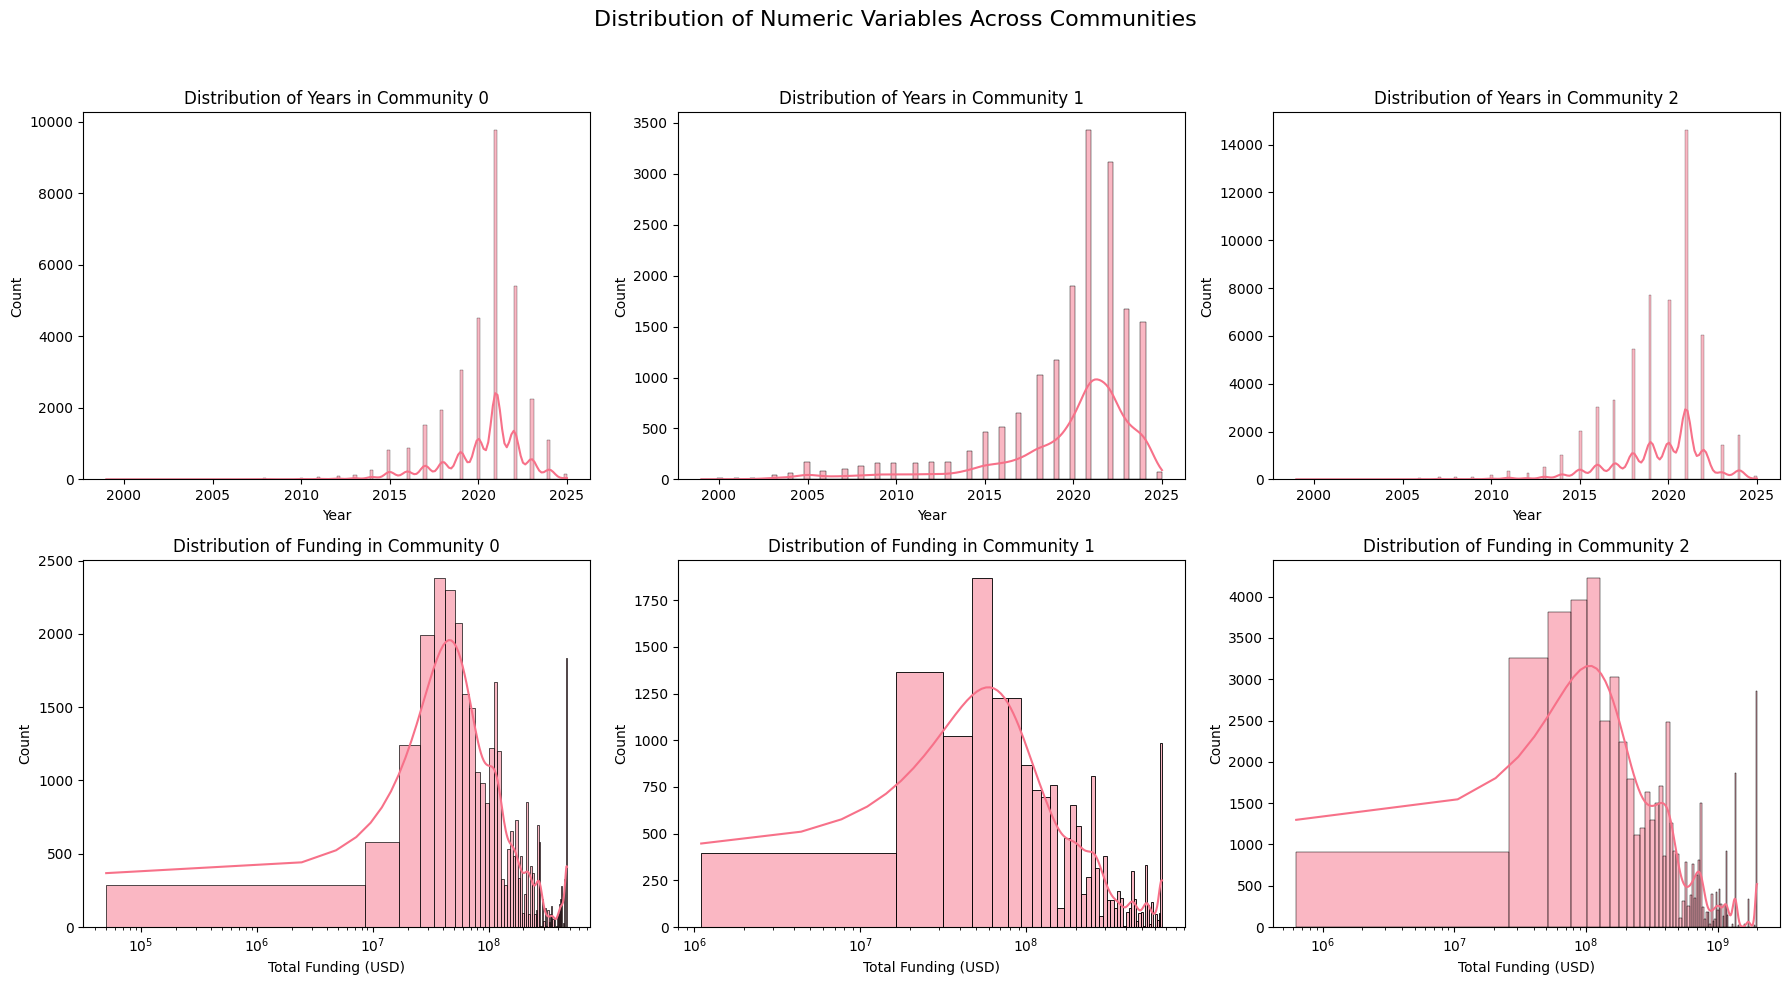

In [53]:
# Plot numeric columns
numeric_columns = ['year', 'total_funding_usd']
fig, axes = plt.subplots(len(numeric_columns), len(communities_of_interest), figsize=(18, 10))
fig.suptitle('Distribution of Numeric Variables Across Communities', fontsize=16)

for row_idx, column in enumerate(numeric_columns):
  for col_idx, comm_id in enumerate(communities_of_interest):
    ax = axes[row_idx, col_idx]
    data = community_data[comm_id]
    
    if len(data) > 0:
      if column == 'total_funding_usd':
        # Log scale and clip outliers
        sns.histplot(data[column].clip(upper=data[column].quantile(0.95), ), kde=True, ax=ax)
        ax.set_xlabel('Total Funding (USD)')
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of Funding in Community {comm_id}')
        ax.set_xscale('log')

      else:
        sns.histplot(data[column], kde=True, ax=ax)
        ax.set_xlabel('Year')
        ax.set_ylabel('Count')
        ax.set_title(f'Distribution of Years in Community {comm_id}')
        
    else:
      ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
      ax.set_title(f'Community {comm_id}')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Categorical Columns

<Figure size 1200x800 with 0 Axes>

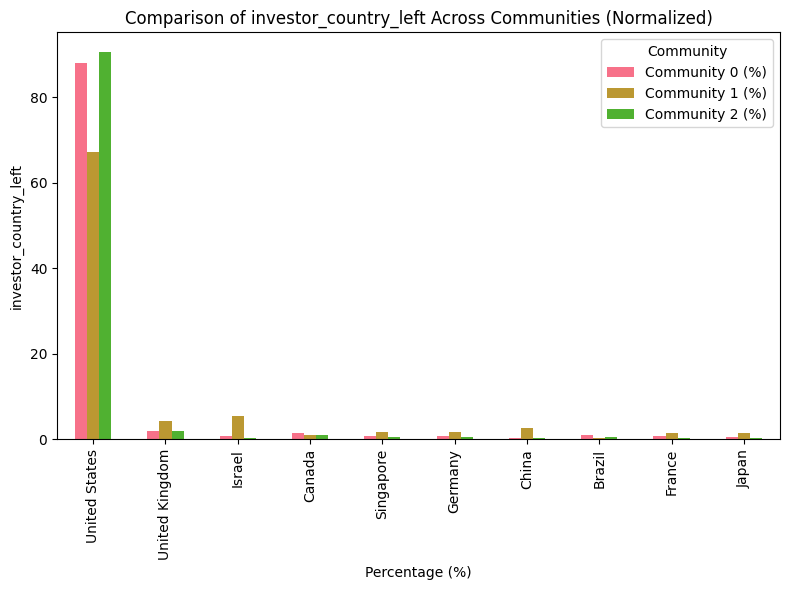

<Figure size 1200x800 with 0 Axes>

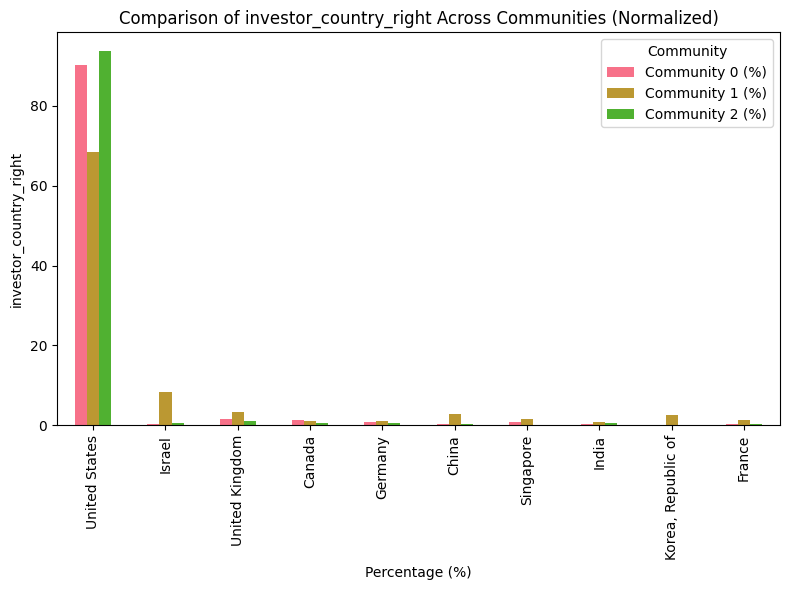

<Figure size 1200x800 with 0 Axes>

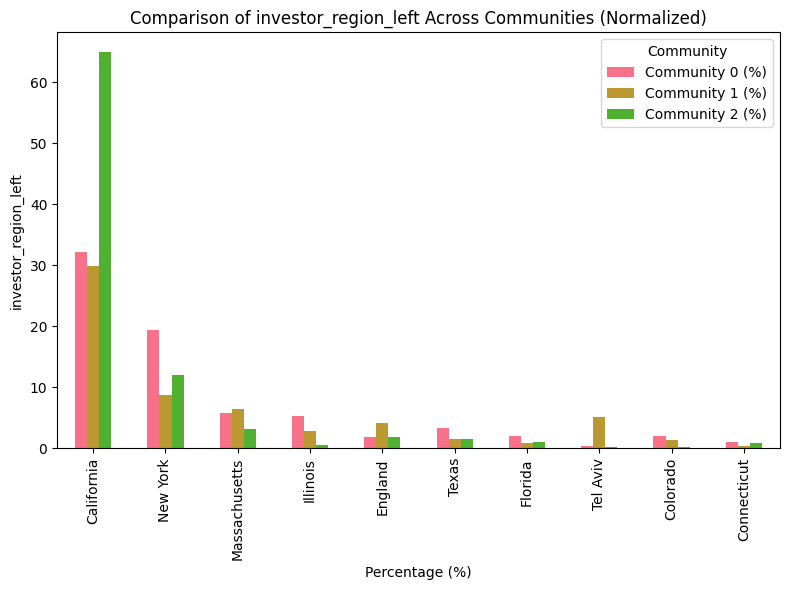

<Figure size 1200x800 with 0 Axes>

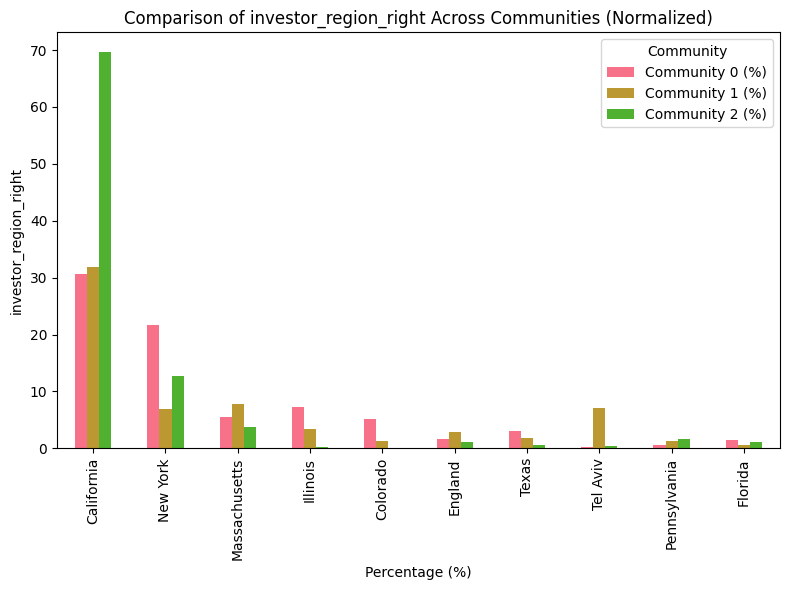

<Figure size 1200x800 with 0 Axes>

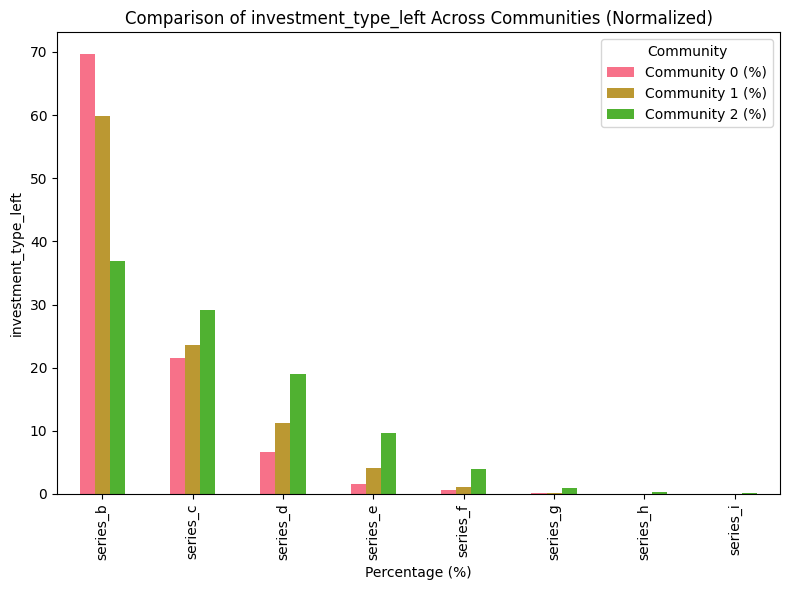

<Figure size 1200x800 with 0 Axes>

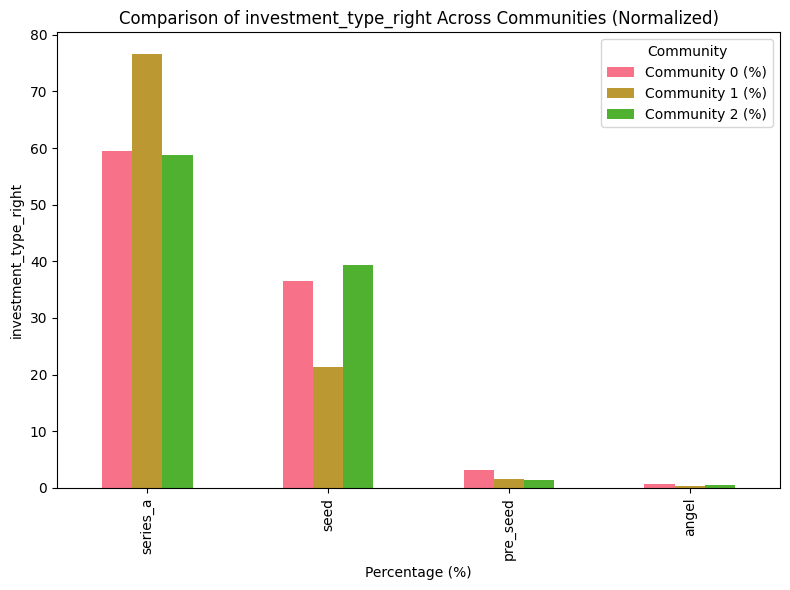

<Figure size 1200x800 with 0 Axes>

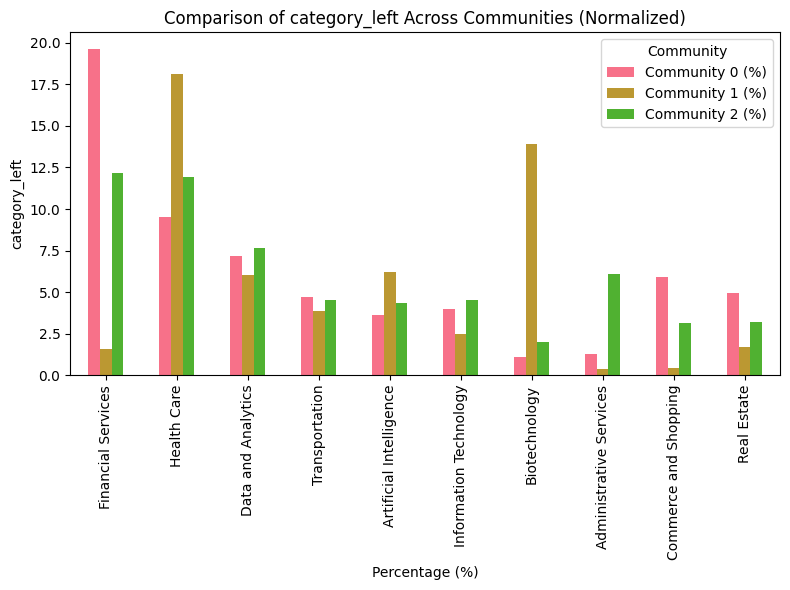

<Figure size 1200x800 with 0 Axes>

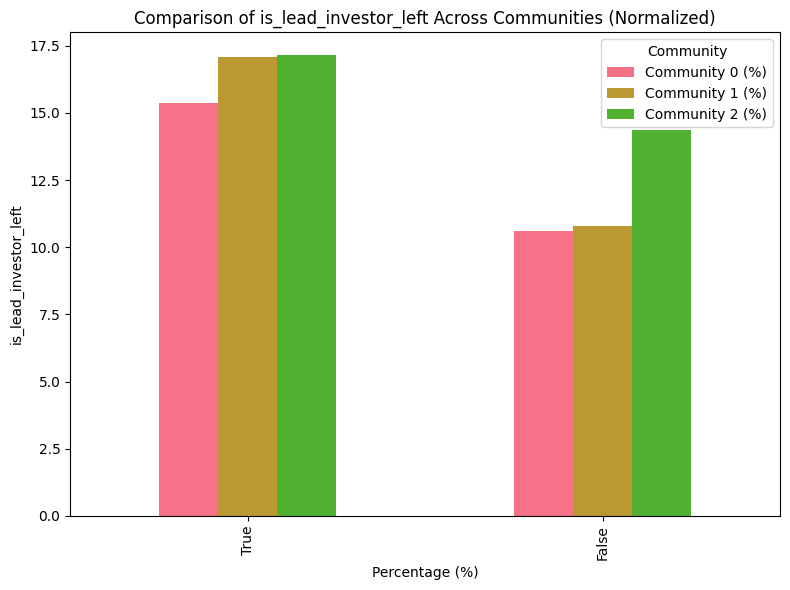

<Figure size 1200x800 with 0 Axes>

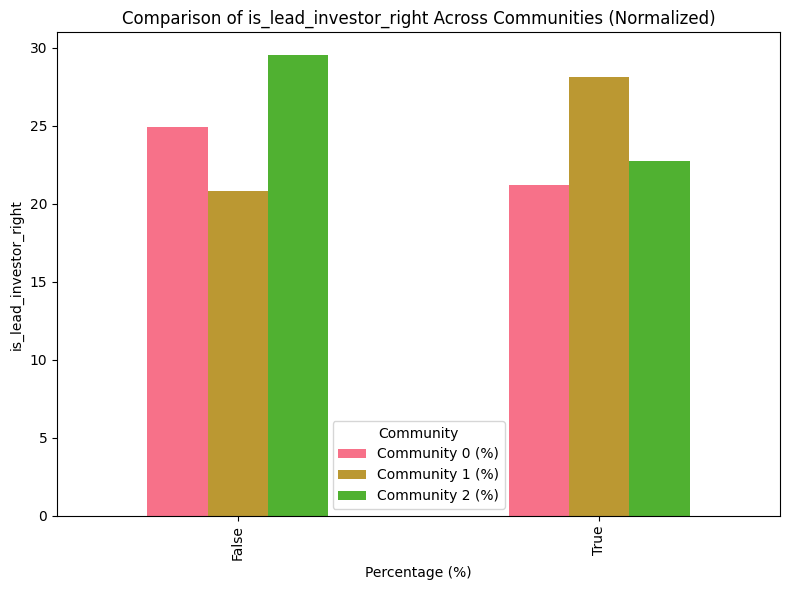

In [55]:
# Plot categorical columns
categorical_columns = [
  'investor_country_left',
  'investor_country_right',
  'investor_region_left',
  'investor_region_right',
  'investment_type_left',
  'investment_type_right',
  'category_left',
  'is_lead_investor_left',
  'is_lead_investor_right',
]

for column in categorical_columns:
  # Get the top 10 categories across all communities
  all_data = pd.concat([community_data[comm_id][column] for col_idx, comm_id in enumerate(communities_of_interest)])
  top_categories = all_data.value_counts().head(10).index.tolist()
  
  # Create a comparison dataframe
  comparison_df = pd.DataFrame(index=top_categories)
  
  for comm_id in communities_of_interest:
    if len(community_data[comm_id]) > 0:
      # Get counts for this community
      counts = community_data[comm_id][column].value_counts()
      # Normalize to percentages
      normalized_counts = counts / len(community_data[comm_id]) * 100
      # Add to comparison df
      comparison_df[f'Community {comm_id} (%)'] = normalized_counts.reindex(comparison_df.index, fill_value=0)
    else:
      comparison_df[f'Community {comm_id} (%)'] = 0
  
  # Truncate long category names
  truncated_index = [truncate_name(cat) for cat in comparison_df.index]
  comparison_df.index = truncated_index
  
  # Plot the comparison
  plt.figure(figsize=(12, 8))
  comparison_df.plot(kind='bar', figsize=(8, 6))
  plt.title(f'Comparison of {column} Across Communities (Normalized)')
  plt.xlabel('Percentage (%)')
  plt.ylabel(column)
  plt.legend(title='Community')
  plt.tight_layout()
  plt.show()

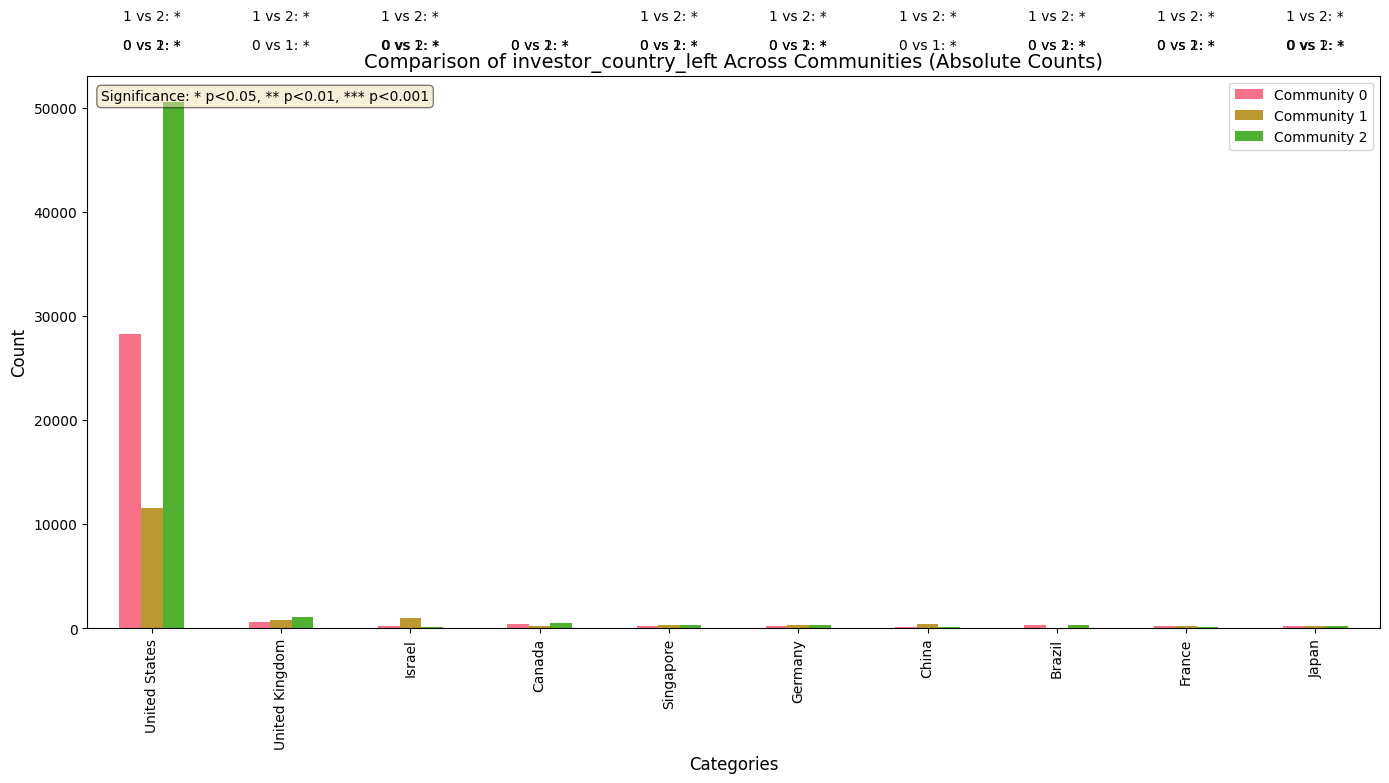


Statistical Summary for investor_country_left:
--------------------------------------------------

Category: United States
  Communities 0 vs 1: counts=28319 vs 11605, props=0.88 vs 0.67, p-value=0.0000 ***
  Communities 0 vs 2: counts=28319 vs 50603, props=0.88 vs 0.91, p-value=0.0000 ***
  Communities 1 vs 2: counts=11605 vs 50603, props=0.67 vs 0.91, p-value=0.0000 ***

Category: United Kingdom
  Communities 0 vs 1: counts=617 vs 756, props=0.02 vs 0.04, p-value=0.0000 ***
  Communities 0 vs 2: counts=617 vs 1094, props=0.02 vs 0.02, p-value=0.6970 
  Communities 1 vs 2: counts=756 vs 1094, props=0.04 vs 0.02, p-value=0.0000 ***

Category: Israel
  Communities 0 vs 1: counts=261 vs 951, props=0.01 vs 0.05, p-value=0.0000 ***
  Communities 0 vs 2: counts=261 vs 148, props=0.01 vs 0.00, p-value=0.0000 ***
  Communities 1 vs 2: counts=951 vs 148, props=0.05 vs 0.00, p-value=0.0000 ***

Category: Canada
  Communities 0 vs 1: counts=446 vs 183, props=0.01 vs 0.01, p-value=0.0021 **
  Co

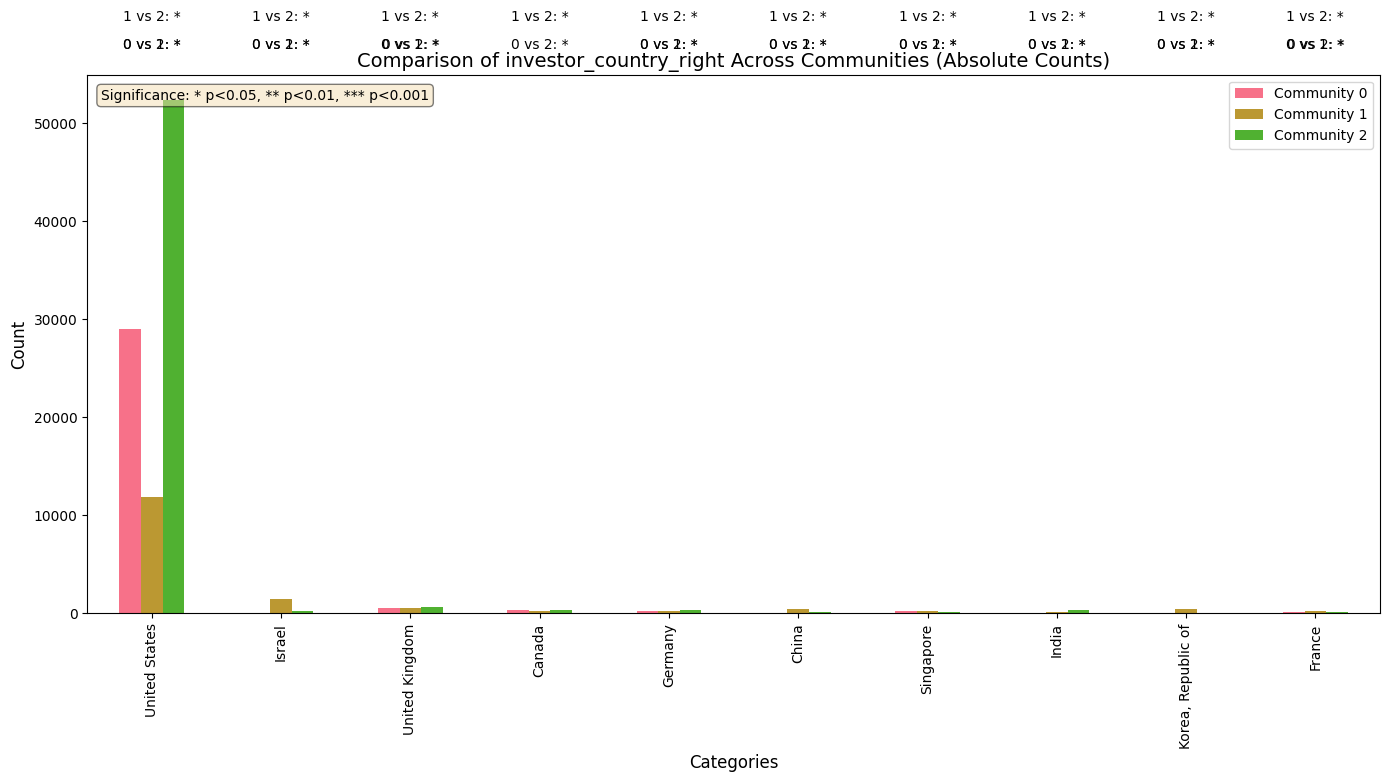


Statistical Summary for investor_country_right:
--------------------------------------------------

Category: United States
  Communities 0 vs 1: counts=29001 vs 11856, props=0.90 vs 0.69, p-value=0.0000 ***
  Communities 0 vs 2: counts=29001 vs 52358, props=0.90 vs 0.94, p-value=0.0000 ***
  Communities 1 vs 2: counts=11856 vs 52358, props=0.69 vs 0.94, p-value=0.0000 ***

Category: Israel
  Communities 0 vs 1: counts=74 vs 1434, props=0.00 vs 0.08, p-value=0.0000 ***
  Communities 0 vs 2: counts=74 vs 271, props=0.00 vs 0.00, p-value=0.0000 ***
  Communities 1 vs 2: counts=1434 vs 271, props=0.08 vs 0.00, p-value=0.0000 ***

Category: United Kingdom
  Communities 0 vs 1: counts=516 vs 562, props=0.02 vs 0.03, p-value=0.0000 ***
  Communities 0 vs 2: counts=516 vs 631, props=0.02 vs 0.01, p-value=0.0000 ***
  Communities 1 vs 2: counts=562 vs 631, props=0.03 vs 0.01, p-value=0.0000 ***

Category: Canada
  Communities 0 vs 1: counts=391 vs 202, props=0.01 vs 0.01, p-value=0.6706 
  Co

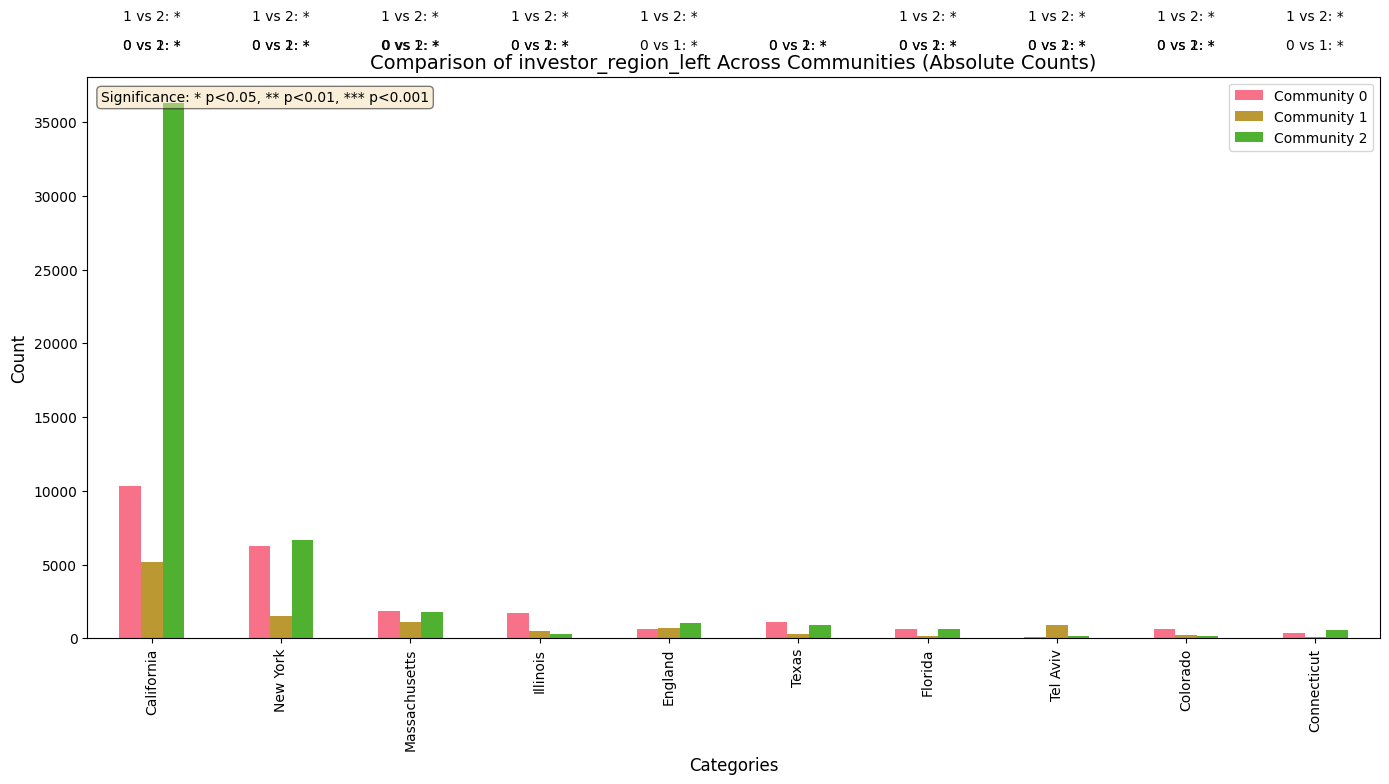


Statistical Summary for investor_region_left:
--------------------------------------------------

Category: California
  Communities 0 vs 1: counts=10357 vs 5175, props=0.32 vs 0.30, p-value=0.0000 ***
  Communities 0 vs 2: counts=10357 vs 36272, props=0.32 vs 0.65, p-value=0.0000 ***
  Communities 1 vs 2: counts=5175 vs 36272, props=0.30 vs 0.65, p-value=0.0000 ***

Category: New York
  Communities 0 vs 1: counts=6249 vs 1501, props=0.19 vs 0.09, p-value=0.0000 ***
  Communities 0 vs 2: counts=6249 vs 6691, props=0.19 vs 0.12, p-value=0.0000 ***
  Communities 1 vs 2: counts=1501 vs 6691, props=0.09 vs 0.12, p-value=0.0000 ***

Category: Massachusetts
  Communities 0 vs 1: counts=1838 vs 1105, props=0.06 vs 0.06, p-value=0.0027 **
  Communities 0 vs 2: counts=1838 vs 1792, props=0.06 vs 0.03, p-value=0.0000 ***
  Communities 1 vs 2: counts=1105 vs 1792, props=0.06 vs 0.03, p-value=0.0000 ***

Category: Illinois
  Communities 0 vs 1: counts=1728 vs 499, props=0.05 vs 0.03, p-value=0.00

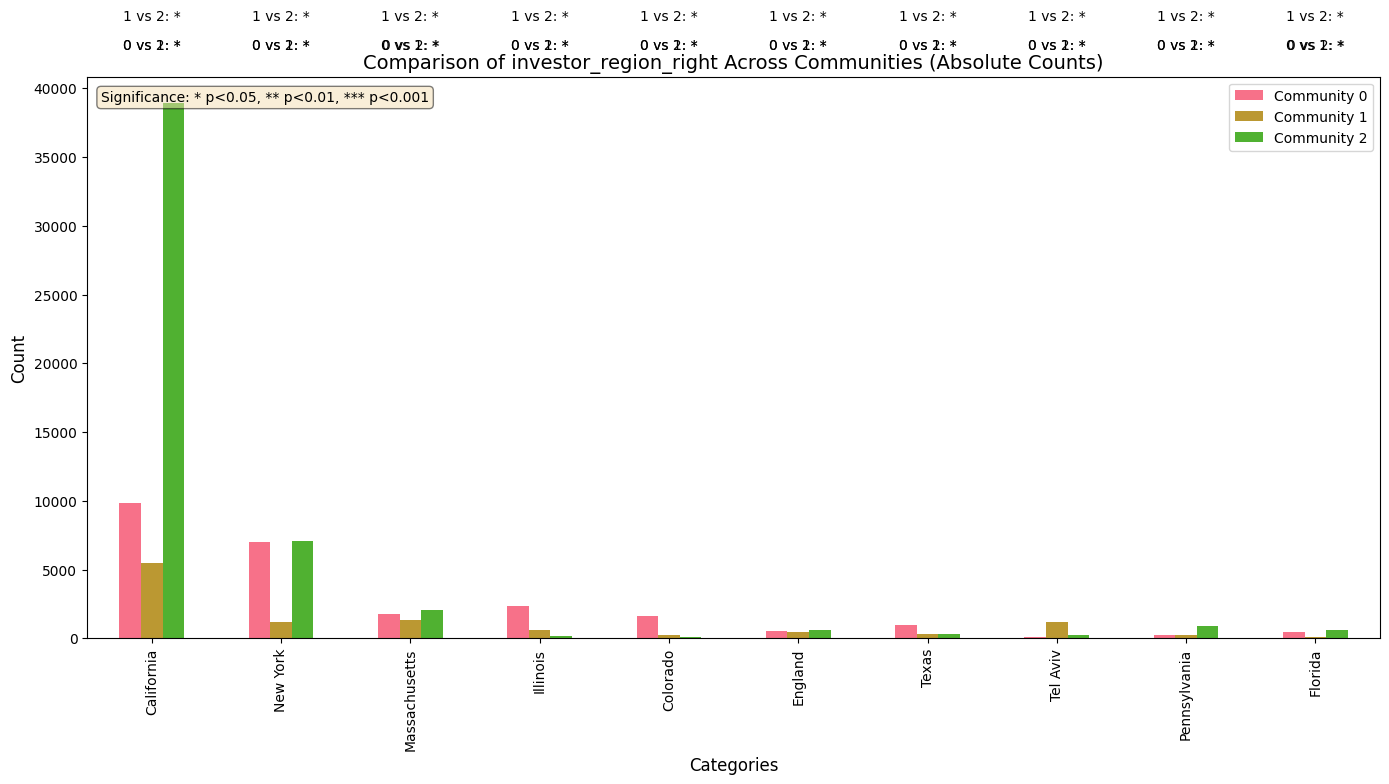


Statistical Summary for investor_region_right:
--------------------------------------------------

Category: California
  Communities 0 vs 1: counts=9833 vs 5502, props=0.31 vs 0.32, p-value=0.0049 **
  Communities 0 vs 2: counts=9833 vs 38903, props=0.31 vs 0.70, p-value=0.0000 ***
  Communities 1 vs 2: counts=5502 vs 38903, props=0.32 vs 0.70, p-value=0.0000 ***

Category: New York
  Communities 0 vs 1: counts=6975 vs 1209, props=0.22 vs 0.07, p-value=0.0000 ***
  Communities 0 vs 2: counts=6975 vs 7105, props=0.22 vs 0.13, p-value=0.0000 ***
  Communities 1 vs 2: counts=1209 vs 7105, props=0.07 vs 0.13, p-value=0.0000 ***

Category: Massachusetts
  Communities 0 vs 1: counts=1760 vs 1349, props=0.05 vs 0.08, p-value=0.0000 ***
  Communities 0 vs 2: counts=1760 vs 2055, props=0.05 vs 0.04, p-value=0.0000 ***
  Communities 1 vs 2: counts=1349 vs 2055, props=0.08 vs 0.04, p-value=0.0000 ***

Category: Illinois
  Communities 0 vs 1: counts=2336 vs 597, props=0.07 vs 0.03, p-value=0.000

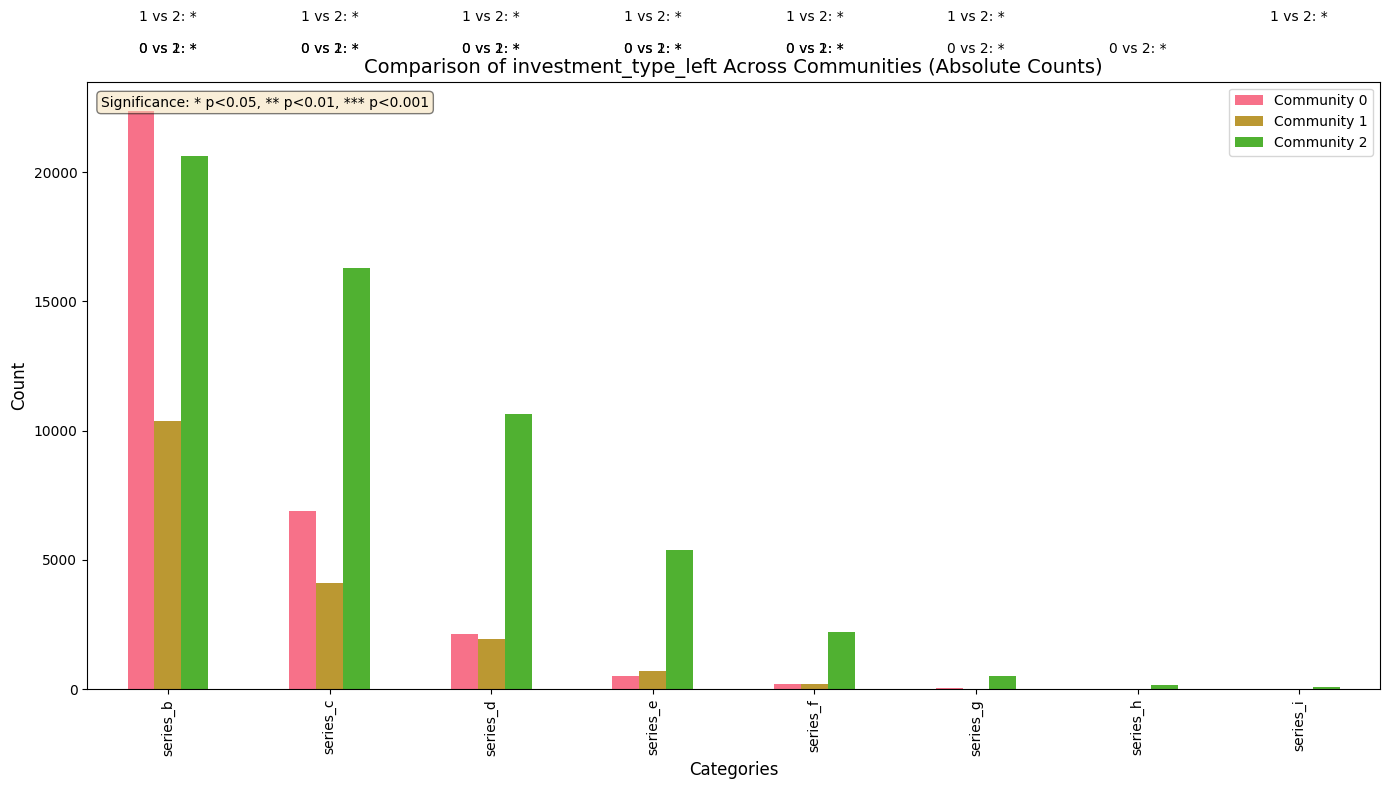


Statistical Summary for investment_type_left:
--------------------------------------------------

Category: series_b
  Communities 0 vs 1: counts=22392 vs 10356, props=0.70 vs 0.60, p-value=0.0000 ***
  Communities 0 vs 2: counts=22392 vs 20631, props=0.70 vs 0.37, p-value=0.0000 ***
  Communities 1 vs 2: counts=10356 vs 20631, props=0.60 vs 0.37, p-value=0.0000 ***

Category: series_c
  Communities 0 vs 1: counts=6901 vs 4092, props=0.21 vs 0.24, p-value=0.0000 ***
  Communities 0 vs 2: counts=6901 vs 16288, props=0.21 vs 0.29, p-value=0.0000 ***
  Communities 1 vs 2: counts=4092 vs 16288, props=0.24 vs 0.29, p-value=0.0000 ***

Category: series_d
  Communities 0 vs 1: counts=2141 vs 1937, props=0.07 vs 0.11, p-value=0.0000 ***
  Communities 0 vs 2: counts=2141 vs 10630, props=0.07 vs 0.19, p-value=0.0000 ***
  Communities 1 vs 2: counts=1937 vs 10630, props=0.11 vs 0.19, p-value=0.0000 ***

Category: series_e
  Communities 0 vs 1: counts=495 vs 706, props=0.02 vs 0.04, p-value=0.000

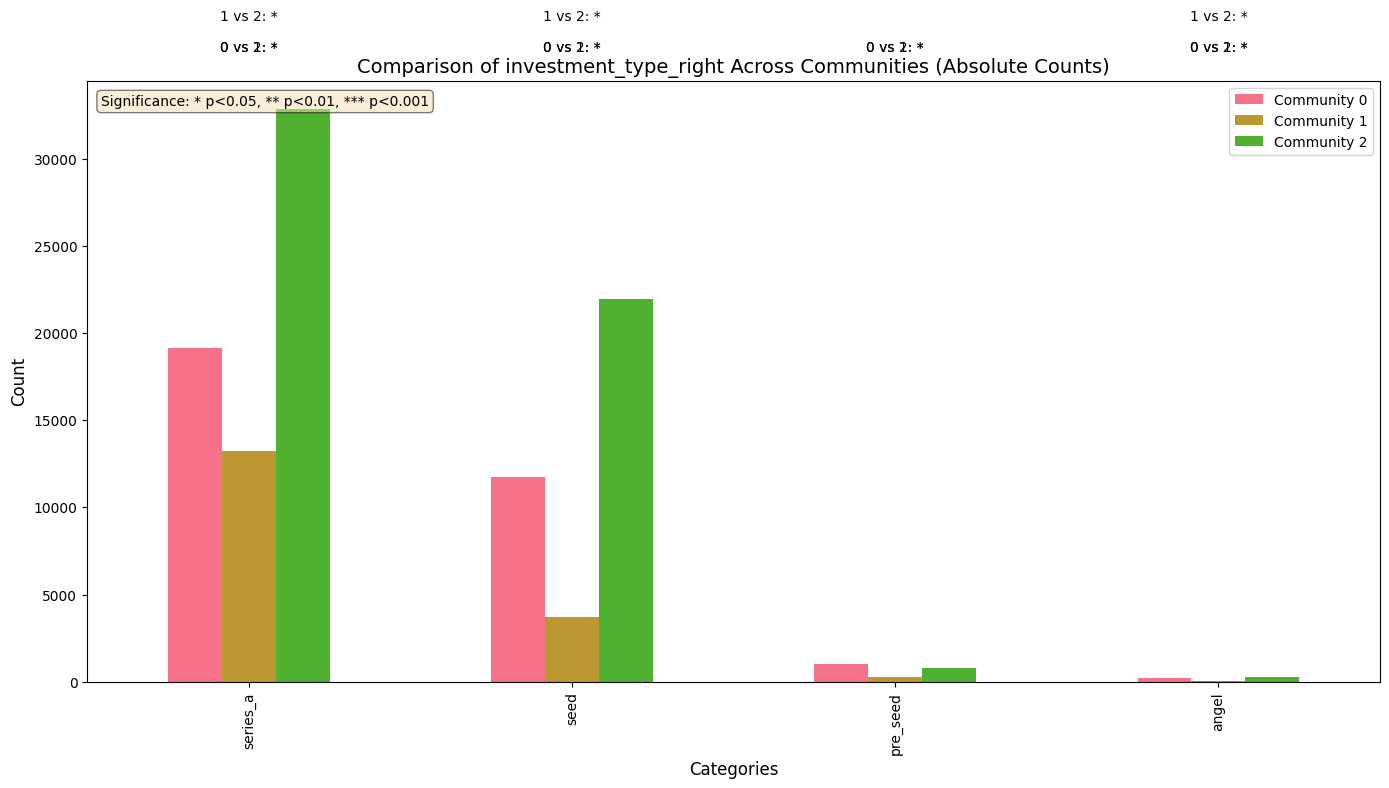


Statistical Summary for investment_type_right:
--------------------------------------------------

Category: series_a
  Communities 0 vs 1: counts=19155 vs 13254, props=0.60 vs 0.77, p-value=0.0000 ***
  Communities 0 vs 2: counts=19155 vs 32827, props=0.60 vs 0.59, p-value=0.0220 *
  Communities 1 vs 2: counts=13254 vs 32827, props=0.77 vs 0.59, p-value=0.0000 ***

Category: seed
  Communities 0 vs 1: counts=11733 vs 3701, props=0.36 vs 0.21, p-value=0.0000 ***
  Communities 0 vs 2: counts=11733 vs 21944, props=0.36 vs 0.39, p-value=0.0000 ***
  Communities 1 vs 2: counts=3701 vs 21944, props=0.21 vs 0.39, p-value=0.0000 ***

Category: pre_seed
  Communities 0 vs 1: counts=1032 vs 283, props=0.03 vs 0.02, p-value=0.0000 ***
  Communities 0 vs 2: counts=1032 vs 812, props=0.03 vs 0.01, p-value=0.0000 ***
  Communities 1 vs 2: counts=283 vs 812, props=0.02 vs 0.01, p-value=0.0913 

Category: angel
  Communities 0 vs 1: counts=244 vs 63, props=0.01 vs 0.00, p-value=0.0000 ***
  Communit

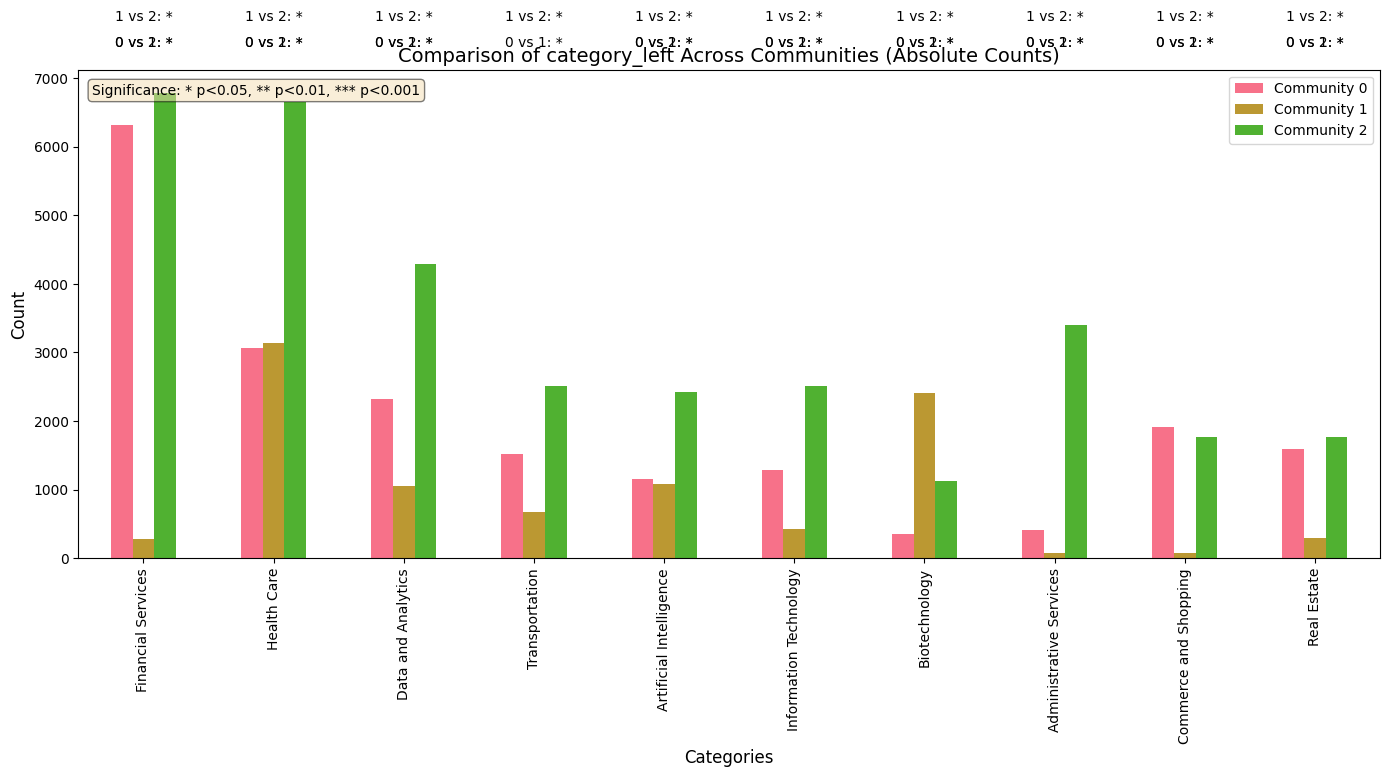


Statistical Summary for category_left:
--------------------------------------------------

Category: Financial Services
  Communities 0 vs 1: counts=6322 vs 274, props=0.20 vs 0.02, p-value=0.0000 ***
  Communities 0 vs 2: counts=6322 vs 6786, props=0.20 vs 0.12, p-value=0.0000 ***
  Communities 1 vs 2: counts=274 vs 6786, props=0.02 vs 0.12, p-value=0.0000 ***

Category: Health Care
  Communities 0 vs 1: counts=3064 vs 3133, props=0.10 vs 0.18, p-value=0.0000 ***
  Communities 0 vs 2: counts=3064 vs 6652, props=0.10 vs 0.12, p-value=0.0000 ***
  Communities 1 vs 2: counts=3133 vs 6652, props=0.18 vs 0.12, p-value=0.0000 ***

Category: Data and Analytics
  Communities 0 vs 1: counts=2315 vs 1046, props=0.07 vs 0.06, p-value=0.0000 ***
  Communities 0 vs 2: counts=2315 vs 4291, props=0.07 vs 0.08, p-value=0.0090 **
  Communities 1 vs 2: counts=1046 vs 4291, props=0.06 vs 0.08, p-value=0.0000 ***

Category: Transportation
  Communities 0 vs 1: counts=1515 vs 670, props=0.05 vs 0.04, p-v

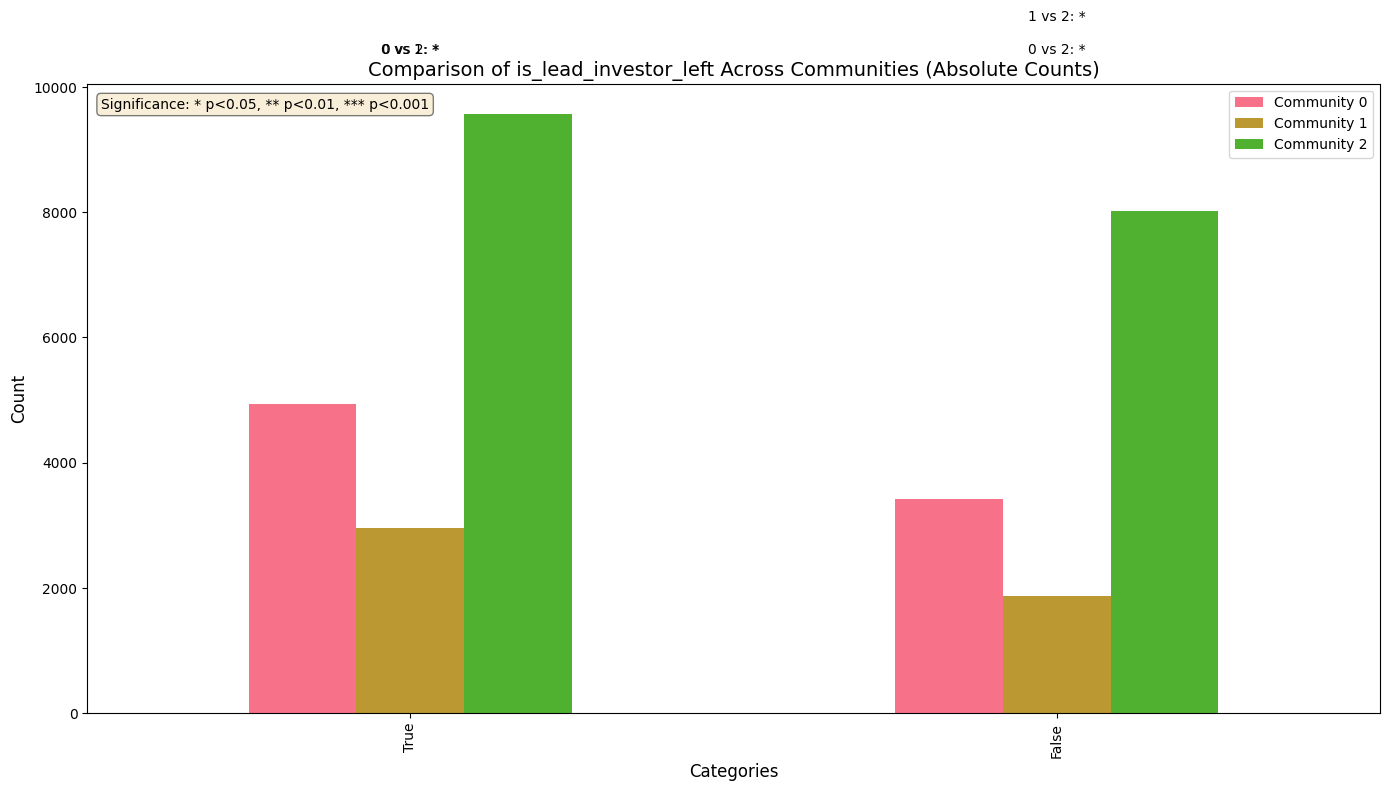


Statistical Summary for is_lead_investor_left:
--------------------------------------------------

Category: True
  Communities 0 vs 1: counts=4939 vs 2957, props=0.15 vs 0.17, p-value=0.0000 ***
  Communities 0 vs 2: counts=4939 vs 9577, props=0.15 vs 0.17, p-value=0.0000 ***
  Communities 1 vs 2: counts=2957 vs 9577, props=0.17 vs 0.17, p-value=0.8825 

Category: False
  Communities 0 vs 1: counts=3412 vs 1864, props=0.11 vs 0.11, p-value=0.5793 
  Communities 0 vs 2: counts=3412 vs 8020, props=0.11 vs 0.14, p-value=0.0000 ***
  Communities 1 vs 2: counts=1864 vs 8020, props=0.11 vs 0.14, p-value=0.0000 ***


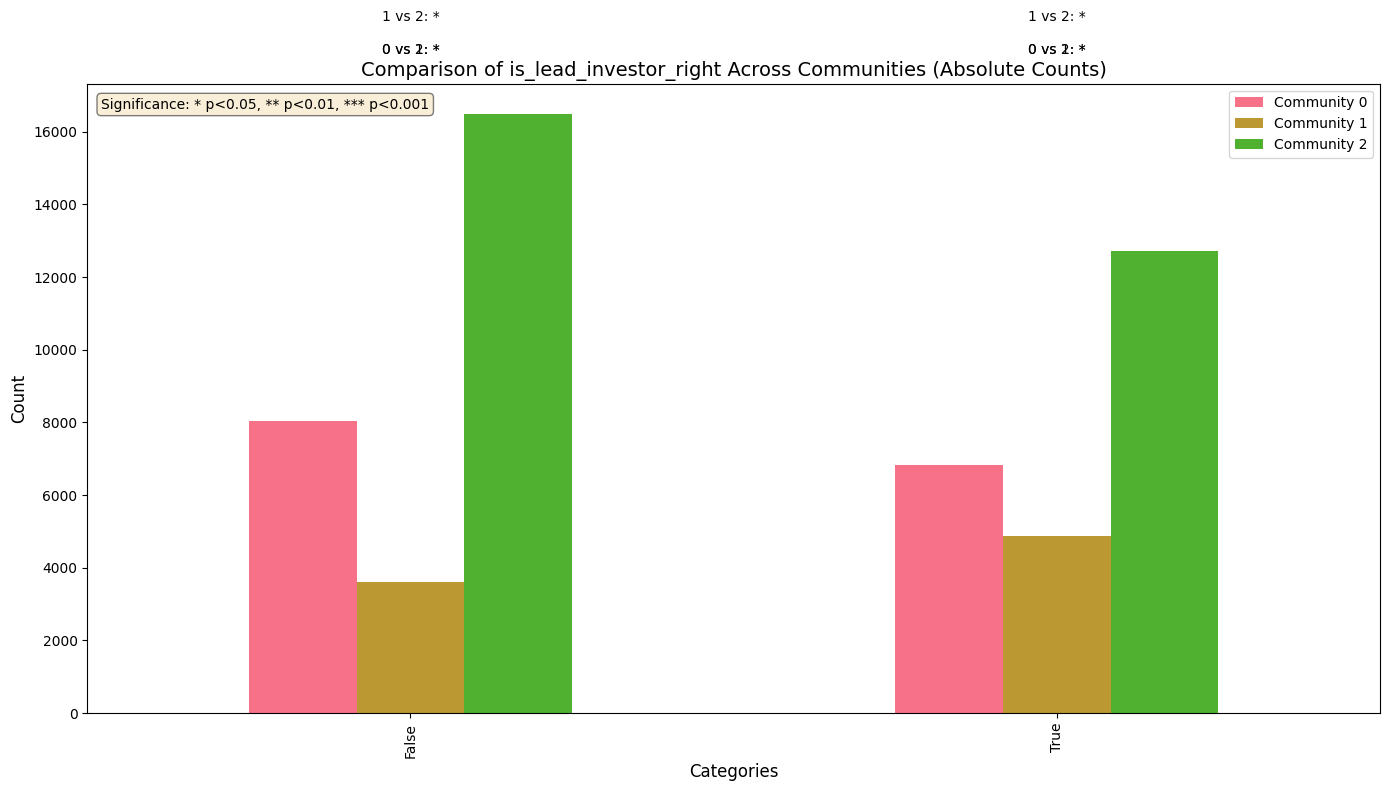


Statistical Summary for is_lead_investor_right:
--------------------------------------------------

Category: False
  Communities 0 vs 1: counts=8028 vs 3603, props=0.25 vs 0.21, p-value=0.0000 ***
  Communities 0 vs 2: counts=8028 vs 16494, props=0.25 vs 0.30, p-value=0.0000 ***
  Communities 1 vs 2: counts=3603 vs 16494, props=0.21 vs 0.30, p-value=0.0000 ***

Category: True
  Communities 0 vs 1: counts=6818 vs 4867, props=0.21 vs 0.28, p-value=0.0000 ***
  Communities 0 vs 2: counts=6818 vs 12721, props=0.21 vs 0.23, p-value=0.0000 ***
  Communities 1 vs 2: counts=4867 vs 12721, props=0.28 vs 0.23, p-value=0.0000 ***


In [56]:
CATEGORICAL_GRAPHS_STATS = False

# Plot categorical columns with absolute counts and statistical significance tests
if CATEGORICAL_GRAPHS_STATS:
    for column in categorical_columns:
        # Get the top 10 categories across all communities
        all_data = pd.concat([community_data[comm_id][column] for comm_id in communities_of_interest])
        top_categories = all_data.value_counts().head(10).index.tolist()
        
        # Create a comparison dataframe with absolute counts
        comparison_df = pd.DataFrame(index=top_categories)
        
        for comm_id in communities_of_interest:
            if len(community_data[comm_id]) > 0:
                # Get absolute counts for this community
                counts = community_data[comm_id][column].value_counts()
                # Add to comparison df
                comparison_df[f'Community {comm_id}'] = counts.reindex(comparison_df.index, fill_value=0)
            else:
                comparison_df[f'Community {comm_id}'] = 0
        
        # Truncate long category names
        truncated_index = [truncate_name(cat) for cat in comparison_df.index]
        comparison_df.index = truncated_index
        
        # Plot the comparison with absolute counts
        fig, ax = plt.subplots(figsize=(14, 8))
        comparison_df.plot(kind='bar', ax=ax)
        
        # Add statistical significance annotations
        y_max = comparison_df.max().max() * 1.1
        
        # Perform chi-square tests between communities for each category
        for idx, category in enumerate(comparison_df.index):
            for i in range(len(communities_of_interest)):
                for j in range(i+1, len(communities_of_interest)):
                    comm1 = communities_of_interest[i]
                    comm2 = communities_of_interest[j]
                    
                    # Get counts for this category in both communities
                    count1 = comparison_df.loc[category, f'Community {comm1}']
                    count2 = comparison_df.loc[category, f'Community {comm2}']
                    
                    # Get total counts for both communities
                    total1 = len(community_data[comm1])
                    total2 = len(community_data[comm2])
                    
                    # Skip if not enough data
                    if count1 < 5 or count2 < 5 or total1 < 10 or total2 < 10:
                        continue
                    
                    # Create contingency table
                    contingency = np.array([
                        [count1, count2],
                        [total1 - count1, total2 - count2]
                    ])
                    
                    # Perform chi-square test
                    _, p_value = stats.chi2_contingency(contingency)[:2]
                    
                    # Add significance markers if significant
                    if p_value < 0.05:
                        marker = '*' if p_value < 0.05 else '**' if p_value < 0.01 else '***' if p_value < 0.001 else ''
                        plt.text(idx, y_max * (1 + 0.05*i), f"{comm1} vs {comm2}: {marker}", ha='center')
        
        # Add title and labels
        plt.title(f'Comparison of {column} Across Communities (Absolute Counts)', fontsize=14)
        plt.xlabel('Categories', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        
        # Add legend explaining significance markers
        legend_text = "Significance: * p<0.05, ** p<0.01, *** p<0.001"
        plt.annotate(legend_text, xy=(0, 1), xycoords='axes fraction',
                    xytext=(10, -10), textcoords='offset points',
                    ha='left', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        # Print a summary table of the statistical tests
        print(f"\nStatistical Summary for {column}:")
        print("-" * 50)
        for category in comparison_df.index[:5]:  # Only show top 5 categories
            print(f"\nCategory: {category}")
            for i in range(len(communities_of_interest)):
                for j in range(i+1, len(communities_of_interest)):
                    comm1 = communities_of_interest[i]
                    comm2 = communities_of_interest[j]
                    
                    # Get counts
                    count1 = comparison_df.loc[category, f'Community {comm1}']
                    count2 = comparison_df.loc[category, f'Community {comm2}']
                    
                    # Get proportions
                    total1 = len(community_data[comm1])
                    total2 = len(community_data[comm2])
                    prop1 = count1 / total1 if total1 > 0 else 0
                    prop2 = count2 / total2 if total2 > 0 else 0
                    
                    # Skip if not enough data
                    if count1 < 5 or count2 < 5 or total1 < 10 or total2 < 10:
                        print(f"  Communities {comm1} vs {comm2}: Not enough data")
                        continue
                    
                    # Create contingency table and perform test
                    contingency = np.array([
                        [count1, count2],
                        [total1 - count1, total2 - count2]
                    ])
                    
                    _, p_value = stats.chi2_contingency(contingency)[:2]
                    
                    # Format result with significance indicator
                    sig = ''
                    if p_value < 0.05: sig = '*'
                    if p_value < 0.01: sig = '**'
                    if p_value < 0.001: sig = '***'
                    
                    print(f"  Communities {comm1} vs {comm2}: counts={count1} vs {count2}, props={prop1:.2f} vs {prop2:.2f}, p-value={p_value:.4f} {sig}")

#### Percentage of local (US and California) and foreign



US vs Foreign Investors Analysis

Community 0 (32164 investment pairs)
------------------------------
Country Distribution:
  Late-stage investors (Left): US 88.0% (28319/32164), Foreign 12.0% (3845/32164)
  Early-stage investors (Right): US 90.2% (29001/32164), Foreign 9.8% (3163/32164)

US Region Distribution:
  Late-stage US investors (Left): California 36.6% (10357/28319), Other US 63.4% (17962/28319)
  Early-stage US investors (Right): California 33.9% (9833/29001), Other US 66.1% (19168/29001)

Community 1 (17301 investment pairs)
------------------------------
Country Distribution:
  Late-stage investors (Left): US 67.1% (11605/17301), Foreign 32.9% (5696/17301)
  Early-stage investors (Right): US 68.5% (11856/17301), Foreign 31.5% (5445/17301)

US Region Distribution:
  Late-stage US investors (Left): California 44.6% (5175/11605), Other US 55.4% (6430/11605)
  Early-stage US investors (Right): California 46.4% (5502/11856), Other US 53.6% (6354/11856)

Community 2 (55863 inv

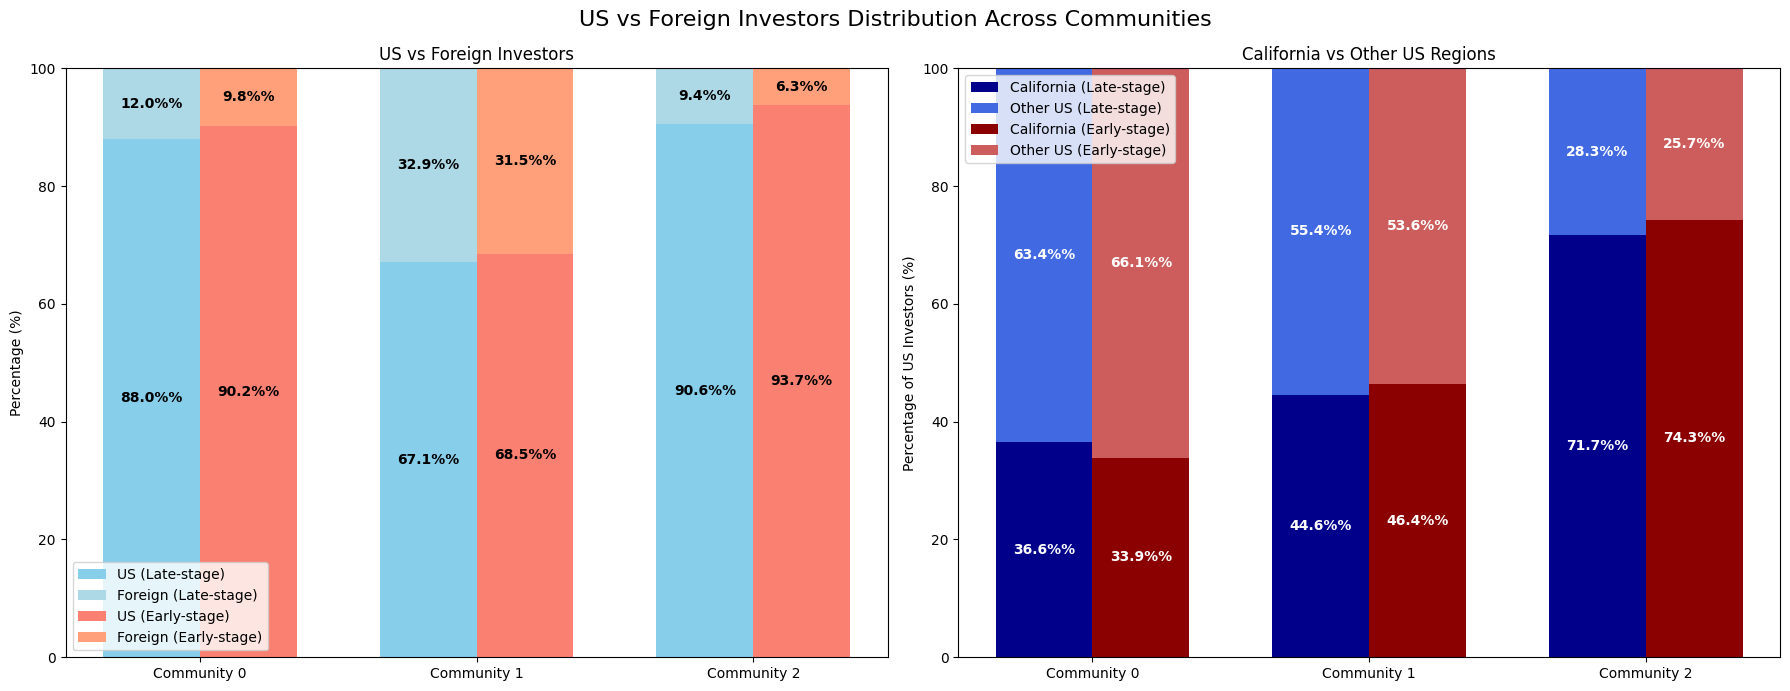

In [57]:
# Calculate percentage of US vs foreign investors for each community
print("\n\nUS vs Foreign Investors Analysis")
print("=" * 50)

# Initialize dictionaries to store results
country_stats = {}
region_stats = {}

for comm_id in communities_of_interest:
    # Get data for this community
    data = community_data[comm_id]
    
    # Country analysis
    country_stats[comm_id] = {}
    
    # Left investors (late-stage investors)
    left_total = len(data)
    left_us = data[data['investor_country_left'] == 'United States'].shape[0]
    left_foreign = left_total - left_us
    left_us_pct = (left_us / left_total * 100) if left_total > 0 else 0
    left_foreign_pct = (left_foreign / left_total * 100) if left_total > 0 else 0
    
    # Right investors (early-stage investors)
    right_total = len(data)
    right_us = data[data['investor_country_right'] == 'United States'].shape[0]
    right_foreign = right_total - right_us
    right_us_pct = (right_us / right_total * 100) if right_total > 0 else 0
    right_foreign_pct = (right_foreign / right_total * 100) if right_total > 0 else 0
    
    # Store results
    country_stats[comm_id]['left_us'] = left_us
    country_stats[comm_id]['left_foreign'] = left_foreign
    country_stats[comm_id]['left_us_pct'] = left_us_pct
    country_stats[comm_id]['left_foreign_pct'] = left_foreign_pct
    country_stats[comm_id]['right_us'] = right_us
    country_stats[comm_id]['right_foreign'] = right_foreign
    country_stats[comm_id]['right_us_pct'] = right_us_pct
    country_stats[comm_id]['right_foreign_pct'] = right_foreign_pct
    
    # Region analysis - California vs Other US regions
    region_stats[comm_id] = {}
    
    # Left investors (late-stage)
    left_us_data = data[data['investor_country_left'] == 'United States']
    left_us_total = len(left_us_data)
    left_california = left_us_data[left_us_data['investor_region_left'] == 'California'].shape[0]
    left_other_us = left_us_total - left_california
    left_california_pct = (left_california / left_us_total * 100) if left_us_total > 0 else 0
    left_other_us_pct = (left_other_us / left_us_total * 100) if left_us_total > 0 else 0
    
    # Right investors (early-stage)
    right_us_data = data[data['investor_country_right'] == 'United States']
    right_us_total = len(right_us_data)
    right_california = right_us_data[right_us_data['investor_region_right'] == 'California'].shape[0]
    right_other_us = right_us_total - right_california
    right_california_pct = (right_california / right_us_total * 100) if right_us_total > 0 else 0
    right_other_us_pct = (right_other_us / right_us_total * 100) if right_us_total > 0 else 0
    
    # Store results
    region_stats[comm_id]['left_california'] = left_california
    region_stats[comm_id]['left_other_us'] = left_other_us
    region_stats[comm_id]['left_california_pct'] = left_california_pct
    region_stats[comm_id]['left_other_us_pct'] = left_other_us_pct
    region_stats[comm_id]['right_california'] = right_california
    region_stats[comm_id]['right_other_us'] = right_other_us
    region_stats[comm_id]['right_california_pct'] = right_california_pct
    region_stats[comm_id]['right_other_us_pct'] = right_other_us_pct

    # Print results
    print(f"\nCommunity {comm_id} ({len(data)} investment pairs)")
    print("-" * 30)
    print("Country Distribution:")
    print(f"  Late-stage investors (Left): US {left_us_pct:.1f}% ({left_us}/{left_total}), Foreign {left_foreign_pct:.1f}% ({left_foreign}/{left_total})")
    print(f"  Early-stage investors (Right): US {right_us_pct:.1f}% ({right_us}/{right_total}), Foreign {right_foreign_pct:.1f}% ({right_foreign}/{right_total})")
    
    print("\nUS Region Distribution:")
    print(f"  Late-stage US investors (Left): California {left_california_pct:.1f}% ({left_california}/{left_us_total}), Other US {left_other_us_pct:.1f}% ({left_other_us}/{left_us_total})")
    print(f"  Early-stage US investors (Right): California {right_california_pct:.1f}% ({right_california}/{right_us_total}), Other US {right_other_us_pct:.1f}% ({right_other_us}/{right_us_total})")

# Create visualizations
# Country distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('US vs Foreign Investors Distribution Across Communities', fontsize=16)

# Data preparation for visualization
country_df = pd.DataFrame({
    'Community': list(communities_of_interest) * 2,
    'Investor Type': ['Late-stage (Left)'] * len(communities_of_interest) + ['Early-stage (Right)'] * len(communities_of_interest),
    'US Percentage': [country_stats[c]['left_us_pct'] for c in communities_of_interest] + 
                    [country_stats[c]['right_us_pct'] for c in communities_of_interest],
    'Foreign Percentage': [country_stats[c]['left_foreign_pct'] for c in communities_of_interest] + 
                         [country_stats[c]['right_foreign_pct'] for c in communities_of_interest]
})

# Bar plot for US vs Foreign
ax = axes[0]
x = np.arange(len(communities_of_interest))
width = 0.35

# Left investors (late-stage)
ax.bar(x - width/2, 
       [country_stats[c]['left_us_pct'] for c in communities_of_interest], 
       width, label='US (Late-stage)', color='skyblue')
ax.bar(x - width/2, 
       [country_stats[c]['left_foreign_pct'] for c in communities_of_interest],
       width, bottom=[country_stats[c]['left_us_pct'] for c in communities_of_interest],
       label='Foreign (Late-stage)', color='lightblue')

# Right investors (early-stage)
ax.bar(x + width/2, 
       [country_stats[c]['right_us_pct'] for c in communities_of_interest], 
       width, label='US (Early-stage)', color='salmon')
ax.bar(x + width/2, 
       [country_stats[c]['right_foreign_pct'] for c in communities_of_interest],
       width, bottom=[country_stats[c]['right_us_pct'] for c in communities_of_interest],
       label='Foreign (Early-stage)', color='lightsalmon')

ax.set_ylabel('Percentage (%)')
ax.set_title('US vs Foreign Investors')
ax.set_xticks(x)
ax.set_xticklabels([f'Community {c}' for c in communities_of_interest])
ax.legend()
ax.set_ylim(0, 100)

# Add value labels on bars
for i, c in enumerate(communities_of_interest):
    # Late-stage US
    ax.text(i - width/2, country_stats[c]['left_us_pct']/2, 
            f"{country_stats[c]['left_us_pct']:.1f}%%", 
            ha='center', va='center', color='black', fontweight='bold')
    
    # Late-stage Foreign
    ax.text(i - width/2, country_stats[c]['left_us_pct'] + country_stats[c]['left_foreign_pct']/2, 
            f"{country_stats[c]['left_foreign_pct']:.1f}%%", 
            ha='center', va='center', color='black', fontweight='bold')
    
    # Early-stage US
    ax.text(i + width/2, country_stats[c]['right_us_pct']/2, 
            f"{country_stats[c]['right_us_pct']:.1f}%%", 
            ha='center', va='center', color='black', fontweight='bold')
    
    # Early-stage Foreign
    ax.text(i + width/2, country_stats[c]['right_us_pct'] + country_stats[c]['right_foreign_pct']/2, 
            f"{country_stats[c]['right_foreign_pct']:.1f}%%", 
            ha='center', va='center', color='black', fontweight='bold')

# Region distribution (California vs Other US)
ax = axes[1]

# Left investors (late-stage)
ax.bar(x - width/2, 
       [region_stats[c]['left_california_pct'] for c in communities_of_interest], 
       width, label='California (Late-stage)', color='darkblue')
ax.bar(x - width/2, 
       [region_stats[c]['left_other_us_pct'] for c in communities_of_interest],
       width, bottom=[region_stats[c]['left_california_pct'] for c in communities_of_interest],
       label='Other US (Late-stage)', color='royalblue')

# Right investors (early-stage)
ax.bar(x + width/2, 
       [region_stats[c]['right_california_pct'] for c in communities_of_interest], 
       width, label='California (Early-stage)', color='darkred')
ax.bar(x + width/2, 
       [region_stats[c]['right_other_us_pct'] for c in communities_of_interest],
       width, bottom=[region_stats[c]['right_california_pct'] for c in communities_of_interest],
       label='Other US (Early-stage)', color='indianred')

ax.set_ylabel('Percentage of US Investors (%)')
ax.set_title('California vs Other US Regions')
ax.set_xticks(x)
ax.set_xticklabels([f'Community {c}' for c in communities_of_interest])
ax.legend()
ax.set_ylim(0, 100)

# Add value labels on bars
for i, c in enumerate(communities_of_interest):
    # Late-stage California
    if region_stats[c]['left_california_pct'] > 5:  # Only show label if enough space
        ax.text(i - width/2, region_stats[c]['left_california_pct']/2, 
                f"{region_stats[c]['left_california_pct']:.1f}%%", 
                ha='center', va='center', color='white', fontweight='bold')
    
    # Late-stage Other US
    if region_stats[c]['left_other_us_pct'] > 5:
        ax.text(i - width/2, region_stats[c]['left_california_pct'] + region_stats[c]['left_other_us_pct']/2, 
                f"{region_stats[c]['left_other_us_pct']:.1f}%%", 
                ha='center', va='center', color='white', fontweight='bold')
    
    # Early-stage California
    if region_stats[c]['right_california_pct'] > 5:
        ax.text(i + width/2, region_stats[c]['right_california_pct']/2, 
                f"{region_stats[c]['right_california_pct']:.1f}%%", 
                ha='center', va='center', color='white', fontweight='bold')
    
    # Early-stage Other US
    if region_stats[c]['right_other_us_pct'] > 5:
        ax.text(i + width/2, region_stats[c]['right_california_pct'] + region_stats[c]['right_other_us_pct']/2, 
                f"{region_stats[c]['right_other_us_pct']:.1f}%%", 
                ha='center', va='center', color='white', fontweight='bold')

# Statistical tests for comparing proportions across communities
print("\n\nStatistical Tests for Community Differences")
print("=" * 50)

# US vs Foreign comparison
print("\nUS vs Foreign Investors Comparison:")
for i in range(len(communities_of_interest)):
    for j in range(i+1, len(communities_of_interest)):
        comm1 = communities_of_interest[i]
        comm2 = communities_of_interest[j]
        
        # Late-stage (left) US proportion test
        count1 = country_stats[comm1]['left_us']
        count2 = country_stats[comm2]['left_us']
        total1 = len(community_data[comm1])
        total2 = len(community_data[comm2])
        
        if count1 >= 5 and count2 >= 5 and total1 >= 20 and total2 >= 20:
            # Create contingency table
            contingency = np.array([
                [count1, count2],
                [total1 - count1, total2 - count2]
            ])
            
            # Perform chi-square test
            _, p_value = stats.chi2_contingency(contingency)[:2]
            
            # Format result with significance indicator
            sig = ''
            if p_value < 0.05: sig = '*'
            if p_value < 0.01: sig = '**'
            if p_value < 0.001: sig = '***'
            
            print(f"  Late-stage US Investors - Communities {comm1} vs {comm2}: {count1/total1*100:.1f}% vs {count2/total2*100:.1f}%, p-value={p_value:.4f} {sig}")
        
        # Early-stage (right) US proportion test
        count1 = country_stats[comm1]['right_us']
        count2 = country_stats[comm2]['right_us']
        
        if count1 >= 5 and count2 >= 5 and total1 >= 20 and total2 >= 20:
            # Create contingency table
            contingency = np.array([
                [count1, count2],
                [total1 - count1, total2 - count2]
            ])
            
            # Perform chi-square test
            _, p_value = stats.chi2_contingency(contingency)[:2]
            
            # Format result with significance indicator
            sig = ''
            if p_value < 0.05: sig = '*'
            if p_value < 0.01: sig = '**'
            if p_value < 0.001: sig = '***'
            
            print(f"  Early-stage US Investors - Communities {comm1} vs {comm2}: {count1/total1*100:.1f}% vs {count2/total2*100:.1f}%, p-value={p_value:.4f} {sig}")

# California vs Other US comparison
print("\nCalifornia vs Other US Regions Comparison:")
for i in range(len(communities_of_interest)):
    for j in range(i+1, len(communities_of_interest)):
        comm1 = communities_of_interest[i]
        comm2 = communities_of_interest[j]
        
        # Late-stage (left) California proportion test
        count1 = region_stats[comm1]['left_california']
        count2 = region_stats[comm2]['left_california']
        total1 = country_stats[comm1]['left_us']
        total2 = country_stats[comm2]['left_us']
        
        if count1 >= 5 and count2 >= 5 and total1 >= 20 and total2 >= 20:
            # Create contingency table
            contingency = np.array([
                [count1, count2],
                [total1 - count1, total2 - count2]
            ])
            
            # Perform chi-square test
            _, p_value = stats.chi2_contingency(contingency)[:2]
            
            # Format result with significance indicator
            sig = ''
            if p_value < 0.05: sig = '*'
            if p_value < 0.01: sig = '**'
            if p_value < 0.001: sig = '***'
            
            print(f"  Late-stage California Investors - Communities {comm1} vs {comm2}: {count1/total1*100:.1f}% vs {count2/total2*100:.1f}%, p-value={p_value:.4f} {sig}")
        
        # Early-stage (right) California proportion test
        count1 = region_stats[comm1]['right_california']
        count2 = region_stats[comm2]['right_california']
        total1 = country_stats[comm1]['right_us']
        total2 = country_stats[comm2]['right_us']
        
        if count1 >= 5 and count2 >= 5 and total1 >= 20 and total2 >= 20:
            # Create contingency table
            contingency = np.array([
                [count1, count2],
                [total1 - count1, total2 - count2]
            ])
            
            # Perform chi-square test
            _, p_value = stats.chi2_contingency(contingency)[:2]
            
            # Format result with significance indicator
            sig = ''
            if p_value < 0.05: sig = '*'
            if p_value < 0.01: sig = '**'
            if p_value < 0.001: sig = '***'
            
            print(f"  Early-stage California Investors - Communities {comm1} vs {comm2}: {count1/total1*100:.1f}% vs {count2/total2*100:.1f}%, p-value={p_value:.4f} {sig}")

plt.tight_layout()
plt.show()

#### Distribution of degrees

In [58]:
# Calculate degree distribution for each community
import networkx as nx

# Calculate degree centrality for all nodes in the bipartite graph
degree_dict = dict(bipartite_graph.degree())

# Initialize storage for community degree distributions
community_degree_distributions = {}

for comm_id in communities_of_interest:
    # Get nodes in this community
    community_nodes = list(top_communities[comm_id])
    
    # Get degrees for nodes in this community
    community_degrees = [degree_dict[node] for node in community_nodes if node in degree_dict]
    
    # Store the distribution
    community_degree_distributions[comm_id] = community_degrees
    
    print(f"Community {comm_id}: {len(community_degrees)} nodes")
    print(f"  Mean degree: {np.mean(community_degrees):.2f}")
    print(f"  Median degree: {np.median(community_degrees):.2f}")
    print(f"  Max degree: {np.max(community_degrees):.0f}")
    print(f"  Min degree: {np.min(community_degrees):.0f}")
    print(f"  Std deviation: {np.std(community_degrees):.2f}")
    print()

Community 0: 4248 nodes
  Mean degree: 21.24
  Median degree: 11.00
  Max degree: 582
  Min degree: 1
  Std deviation: 35.93

Community 1: 4089 nodes
  Mean degree: 11.84
  Median degree: 7.00
  Max degree: 240
  Min degree: 1
  Std deviation: 16.49

Community 2: 3959 nodes
  Mean degree: 33.66
  Median degree: 13.00
  Max degree: 974
  Min degree: 1
  Std deviation: 61.23



C:\Users\joao.melga\AppData\Local\Temp\ipykernel_15176\1644805397.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(degree_data, labels=labels, patch_artist=True)


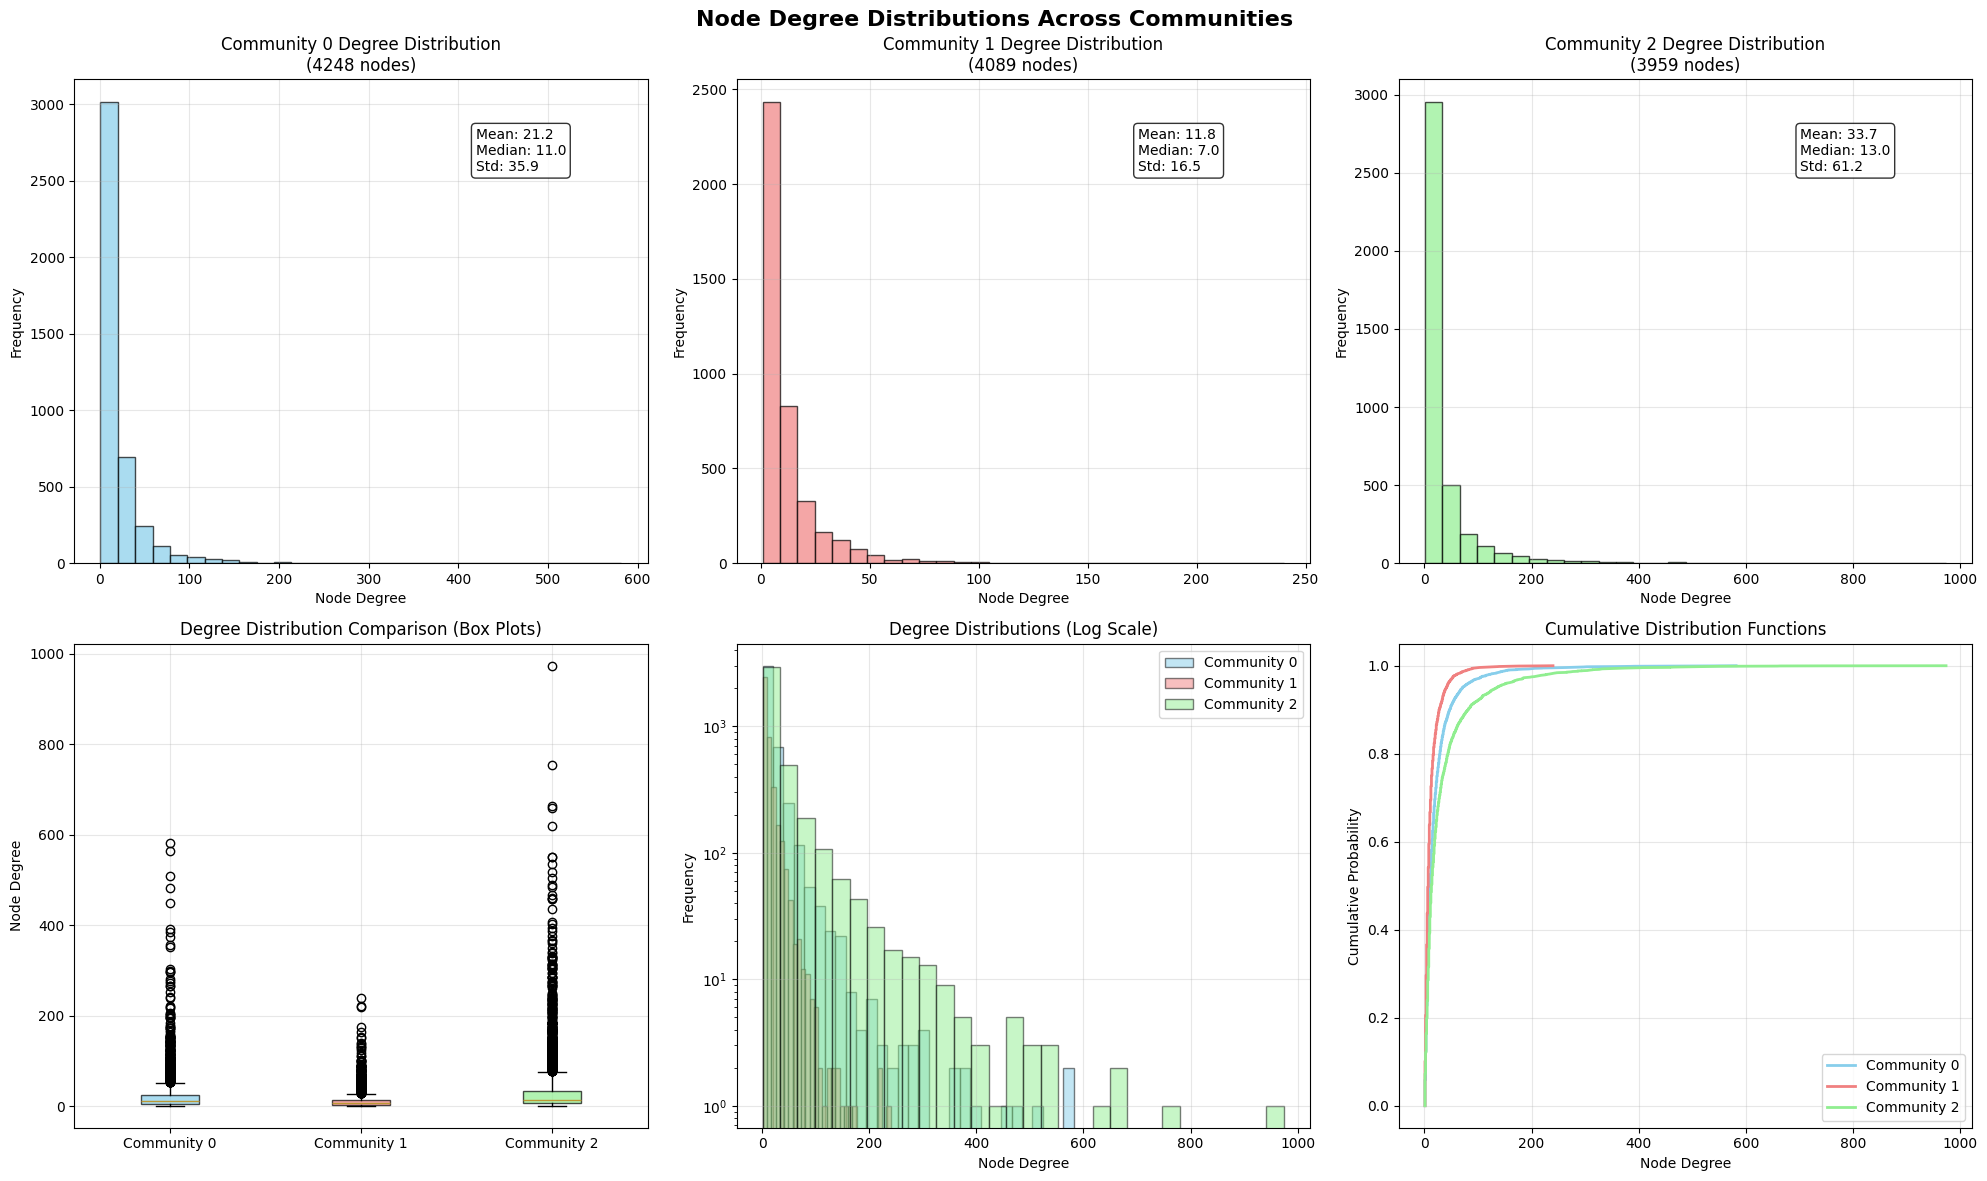

In [59]:
# Create comprehensive degree distribution plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Node Degree Distributions Across Communities', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Colors for each community
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Plot 1: Histograms for each community
for i, comm_id in enumerate(communities_of_interest):
    ax = axes_flat[i]
    degrees = community_degree_distributions[comm_id]
    
    # Create histogram
    ax.hist(degrees, bins=30, alpha=0.7, color=colors[i], edgecolor='black')
    ax.set_title(f'Community {comm_id} Degree Distribution\n({len(degrees)} nodes)')
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f'Mean: {np.mean(degrees):.1f}\nMedian: {np.median(degrees):.1f}\nStd: {np.std(degrees):.1f}'
    ax.text(0.7, 0.9, stats_text, transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top')

# Plot 4: Comparison of degree distributions (box plots)
ax = axes_flat[3]
degree_data = [community_degree_distributions[comm_id] for comm_id in communities_of_interest]
labels = [f'Community {comm_id}' for comm_id in communities_of_interest]

bp = ax.boxplot(degree_data, labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title('Degree Distribution Comparison (Box Plots)')
ax.set_ylabel('Node Degree')
ax.grid(True, alpha=0.3)

# Plot 5: Log-scale histograms (to better see heavy tails)
ax = axes_flat[4]
for i, comm_id in enumerate(communities_of_interest):
    degrees = community_degree_distributions[comm_id]
    ax.hist(degrees, bins=30, alpha=0.5, label=f'Community {comm_id}', 
            color=colors[i], edgecolor='black')

ax.set_title('Degree Distributions (Log Scale)')
ax.set_xlabel('Node Degree')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: Cumulative distribution functions
ax = axes_flat[5]
for i, comm_id in enumerate(communities_of_interest):
    degrees = np.array(community_degree_distributions[comm_id])
    degrees_sorted = np.sort(degrees)
    cdf = np.arange(1, len(degrees_sorted) + 1) / len(degrees_sorted)
    
    ax.plot(degrees_sorted, cdf, label=f'Community {comm_id}', 
            color=colors[i], linewidth=2)

ax.set_title('Cumulative Distribution Functions')
ax.set_xlabel('Node Degree')
ax.set_ylabel('Cumulative Probability')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [60]:
# Statistical tests for degree distribution differences
from scipy import stats

print("Statistical Tests for Degree Distribution Differences")
print("=" * 60)

# Kolmogorov-Smirnov tests between communities
print("\nKolmogorov-Smirnov Tests (comparing distributions):")
for i in range(len(communities_of_interest)):
    for j in range(i+1, len(communities_of_interest)):
        comm1 = communities_of_interest[i]
        comm2 = communities_of_interest[j]
        
        degrees1 = community_degree_distributions[comm1]
        degrees2 = community_degree_distributions[comm2]
        
        # Perform KS test
        ks_stat, p_value = stats.ks_2samp(degrees1, degrees2)
        
        # Format result with significance indicator
        sig = ''
        if p_value < 0.05: sig = '*'
        if p_value < 0.01: sig = '**'
        if p_value < 0.001: sig = '***'
        
        print(f"  Communities {comm1} vs {comm2}: KS statistic = {ks_stat:.4f}, p-value = {p_value:.4f} {sig}")

# Mann-Whitney U tests for median differences
print("\nMann-Whitney U Tests (comparing medians):")
for i in range(len(communities_of_interest)):
    for j in range(i+1, len(communities_of_interest)):
        comm1 = communities_of_interest[i]
        comm2 = communities_of_interest[j]
        
        degrees1 = community_degree_distributions[comm1]
        degrees2 = community_degree_distributions[comm2]
        
        # Perform Mann-Whitney U test
        u_stat, p_value = stats.mannwhitneyu(degrees1, degrees2, alternative='two-sided')
        
        # Format result with significance indicator
        sig = ''
        if p_value < 0.05: sig = '*'
        if p_value < 0.01: sig = '**'
        if p_value < 0.001: sig = '***'
        
        median1 = np.median(degrees1)
        median2 = np.median(degrees2)
        
        print(f"  Communities {comm1} vs {comm2}: medians = {median1:.1f} vs {median2:.1f}, p-value = {p_value:.4f} {sig}")

# Summary statistics table
print("\nSummary Statistics Table:")
print("-" * 80)
print(f"{'Community':<12} {'Nodes':<8} {'Mean':<8} {'Median':<8} {'Std':<8} {'Min':<6} {'Max':<6} {'Skewness':<10}")
print("-" * 80)

for comm_id in communities_of_interest:
    degrees = community_degree_distributions[comm_id]
    mean_deg = np.mean(degrees)
    median_deg = np.median(degrees)
    std_deg = np.std(degrees)
    min_deg = np.min(degrees)
    max_deg = np.max(degrees)
    skewness = stats.skew(degrees)
    
    print(f"{comm_id:<12} {len(degrees):<8} {mean_deg:<8.1f} {median_deg:<8.1f} {std_deg:<8.1f} {min_deg:<6.0f} {max_deg:<6.0f} {skewness:<10.2f}")

Statistical Tests for Degree Distribution Differences

Kolmogorov-Smirnov Tests (comparing distributions):
  Communities 0 vs 1: KS statistic = 0.1795, p-value = 0.0000 ***
  Communities 0 vs 2: KS statistic = 0.0969, p-value = 0.0000 ***
  Communities 1 vs 2: KS statistic = 0.2474, p-value = 0.0000 ***

Mann-Whitney U Tests (comparing medians):
  Communities 0 vs 1: medians = 11.0 vs 7.0, p-value = 0.0000 ***
  Communities 0 vs 2: medians = 11.0 vs 13.0, p-value = 0.0000 ***
  Communities 1 vs 2: medians = 7.0 vs 13.0, p-value = 0.0000 ***

Summary Statistics Table:
--------------------------------------------------------------------------------
Community    Nodes    Mean     Median   Std      Min    Max    Skewness  
--------------------------------------------------------------------------------
0            4248     21.2     11.0     35.9     1      582    6.44      
1            4089     11.8     7.0      16.5     1      240    4.62      
2            3959     33.7     13.0     61

In [62]:
# Analyze high-degree nodes (hubs) in each community
print("High-Degree Nodes (Hubs) Analysis")
print("=" * 50)

show_top = 20

for comm_id in communities_of_interest:
    degrees = community_degree_distributions[comm_id]
    community_nodes = list(top_communities[comm_id])
    
    # Find nodes with degrees in top 5%
    threshold_95 = np.percentile(degrees, 95)
    
    # Get high-degree nodes
    high_degree_nodes = []
    for node in community_nodes:
        if node in degree_dict and degree_dict[node] >= threshold_95:
            high_degree_nodes.append((node, degree_dict[node]))
    
    # Sort by degree (descending)
    high_degree_nodes.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nCommunity {comm_id} - Top High-Degree Nodes (95th percentile, threshold={threshold_95:.1f}):")
    print("-" * 60)
    
    for i, (node, degree) in enumerate(high_degree_nodes[:show_top]):  # Show top show_top
        # Determine if it's a left or right node
        node_type = 'Late-stage' if node in set_0 else 'Early-stage'
        print(f"  {i+1:2d}. {node:<40} (degree: {degree:3d}, type: {node_type})")
    
    if len(high_degree_nodes) > show_top:
        print(f"     ... and {len(high_degree_nodes) - show_top} more high-degree nodes")
    
    # Calculate percentage of high-degree nodes by type
    left_hubs = sum(1 for node, _ in high_degree_nodes if node in set_0)
    right_hubs = sum(1 for node, _ in high_degree_nodes if node in set_1)
    total_hubs = len(high_degree_nodes)
    
    if total_hubs > 0:
        left_pct = (left_hubs / total_hubs) * 100
        right_pct = (right_hubs / total_hubs) * 100
        print(f"     Hub distribution: {left_hubs} late-stage ({left_pct:.1f}%), {right_hubs} early-stage ({right_pct:.1f}%)")

High-Degree Nodes (Hubs) Analysis

Community 0 - Top High-Degree Nodes (95th percentile, threshold=71.0):
------------------------------------------------------------
   1. Techstars-seed                           (degree: 582, type: Early-stage)
   2. 500 Global-seed                          (degree: 564, type: Early-stage)
   3. Gaingels-series_b                        (degree: 509, type: Late-stage)
   4. Greycroft-series_a                       (degree: 483, type: Early-stage)
   5. Bossa Invest-series_b                    (degree: 450, type: Late-stage)
   6. New Enterprise Associates-series_b       (degree: 392, type: Late-stage)
   7. FJ Labs-series_b                         (degree: 385, type: Late-stage)
   8. Lerer Hippeau-series_a                   (degree: 375, type: Early-stage)
   9. RRE Ventures-series_a                    (degree: 356, type: Early-stage)
  10. 500 Global-series_a                      (degree: 353, type: Early-stage)
  11. Techstars-pre_seed             

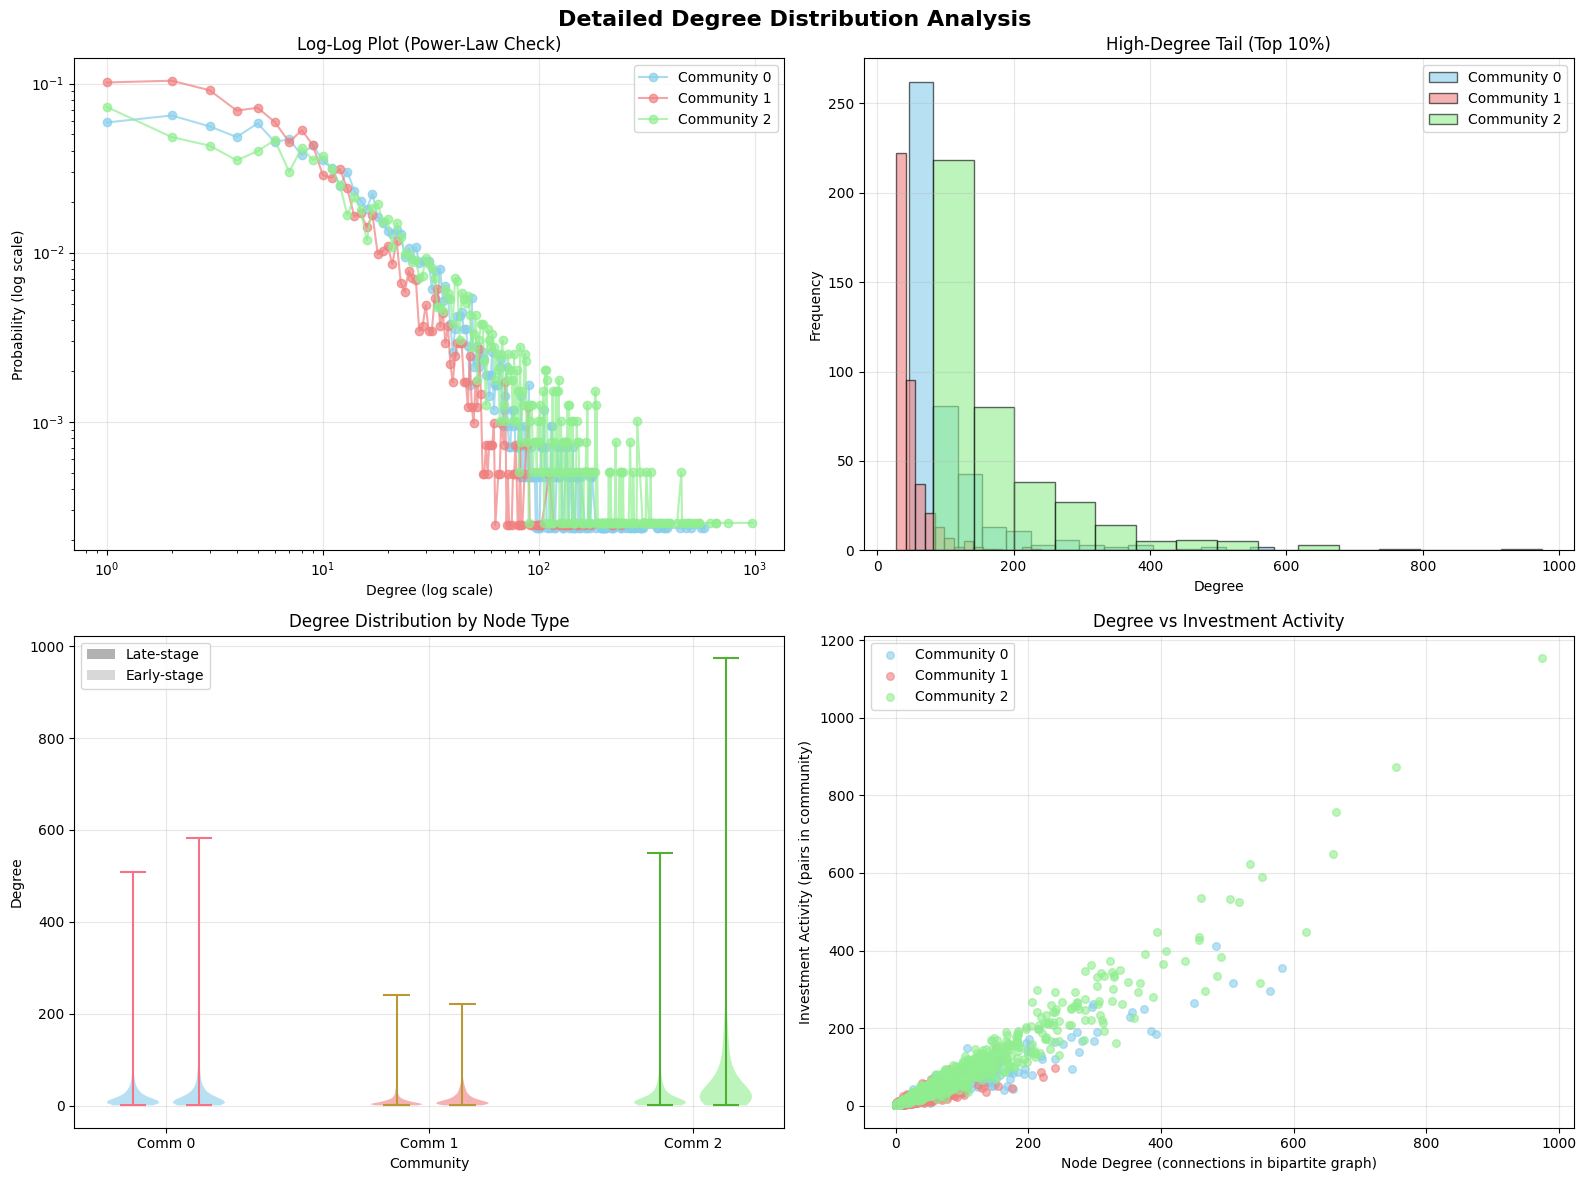

In [63]:
# Create a detailed degree analysis plot focused on the tails of the distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Detailed Degree Distribution Analysis', fontsize=16, fontweight='bold')

# Plot 1: Log-log plot to check for power-law behavior
ax = axes[0, 0]
for i, comm_id in enumerate(communities_of_interest):
    degrees = np.array(community_degree_distributions[comm_id])
    
    # Calculate degree distribution (probability mass function)
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    probabilities = counts / len(degrees)
    
    # Filter out zeros for log-log plot
    mask = (unique_degrees > 0) & (probabilities > 0)
    unique_degrees_filtered = unique_degrees[mask]
    probabilities_filtered = probabilities[mask]
    
    ax.loglog(unique_degrees_filtered, probabilities_filtered, 
             'o-', label=f'Community {comm_id}', color=colors[i], alpha=0.7)

ax.set_title('Log-Log Plot (Power-Law Check)')
ax.set_xlabel('Degree (log scale)')
ax.set_ylabel('Probability (log scale)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Focus on high-degree tail (top 10%)
ax = axes[0, 1]
for i, comm_id in enumerate(communities_of_interest):
    degrees = np.array(community_degree_distributions[comm_id])
    threshold_90 = np.percentile(degrees, 90)
    high_degrees = degrees[degrees >= threshold_90]
    
    ax.hist(high_degrees, bins=15, alpha=0.6, label=f'Community {comm_id}', 
            color=colors[i], edgecolor='black')

ax.set_title('High-Degree Tail (Top 10%)')
ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Degree vs Node Type distribution
ax = axes[1, 0]
for i, comm_id in enumerate(communities_of_interest):
    community_nodes = list(top_communities[comm_id])
    
    left_degrees = [degree_dict[node] for node in community_nodes if node in set_0 and node in degree_dict]
    right_degrees = [degree_dict[node] for node in community_nodes if node in set_1 and node in degree_dict]
    
    # Create violin plots
    positions = [i*2, i*2+0.5]
    parts = ax.violinplot([left_degrees, right_degrees], positions=positions, widths=0.4)
    
    # Color the violin plots
    for pc, color in zip(parts['bodies'], [colors[i], colors[i]]):
        pc.set_facecolor(color)
        pc.set_alpha(0.6)

# Customize the violin plot
ax.set_title('Degree Distribution by Node Type')
ax.set_xlabel('Community')
ax.set_ylabel('Degree')
ax.set_xticks([0.25, 2.25, 4.25])
ax.set_xticklabels([f'Comm {i}' for i in communities_of_interest])
ax.grid(True, alpha=0.3)

# Add legend for node types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='gray', alpha=0.6, label='Late-stage'),
                  Patch(facecolor='gray', alpha=0.3, label='Early-stage')]
ax.legend(handles=legend_elements)

# Plot 4: Degree correlation with investment activity
ax = axes[1, 1]

# For each community, plot degree vs some measure of activity
for i, comm_id in enumerate(communities_of_interest):
    community_nodes = list(top_communities[comm_id])
    community_data_subset = community_data[comm_id]
    
    # Count investment pairs for each investor
    investor_activity = {}
    for _, row in community_data_subset.iterrows():
        left_inv = row['investor_name_left']
        right_inv = row['investor_name_right']
        
        investor_activity[left_inv] = investor_activity.get(left_inv, 0) + 1
        investor_activity[right_inv] = investor_activity.get(right_inv, 0) + 1
    
    # Create scatter plot of degree vs activity
    degrees_plot = []
    activities_plot = []
    
    for node in community_nodes:
        if node in degree_dict and node in investor_activity:
            degrees_plot.append(degree_dict[node])
            activities_plot.append(investor_activity[node])
    
    if degrees_plot and activities_plot:
        ax.scatter(degrees_plot, activities_plot, alpha=0.6, 
                  label=f'Community {comm_id}', color=colors[i], s=30)

ax.set_title('Degree vs Investment Activity')
ax.set_xlabel('Node Degree (connections in bipartite graph)')
ax.set_ylabel('Investment Activity (pairs in community)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Nestedness Evolution

#### Nestedness Evolution for Community 2

Analysis of nestedness evolution over time for community 2 using cumulative 5-year windows and curve ball null models.

In [66]:
# Focus on community 2 for temporal nestedness analysis
target_community = 2
community_2_data = community_data[target_community].copy()

print(f"Community {target_community} temporal analysis")
print(f"Total investment pairs: {len(community_2_data)}")
print(f"Year range: {community_2_data['year'].min()} to {community_2_data['year'].max()}")

# Show year distribution
year_counts = community_2_data['year'].value_counts().sort_index()
print(f"\nInvestment pairs per year:")
print(year_counts)

Community 2 temporal analysis
Total investment pairs: 55863
Year range: 1999 to 2025

Investment pairs per year:
year
1999        5
2000       13
2001        8
2002       13
2003       13
2004       21
2005       36
2006       47
2007       90
2008       81
2009       82
2010      165
2011      342
2012      253
2013      531
2014     1031
2015     2020
2016     3033
2017     3304
2018     5434
2019     7706
2020     7499
2021    14618
2022     6047
2023     1446
2024     1876
2025      149
Name: count, dtype: int64


In [81]:
# Initialize storage for community 2 time series nestedness analysis
community_2_nestedness_ts = []
cumulative_window = 21
min_edges_threshold = 10

print(f"Computing nestedness evolution for Community {target_community} ({cumulative_window}-year cumulative windows)...")
print("=" * 70)

# Get community 2 nodes from the bipartite graph
community_2_nodes = set(top_communities[target_community])

# Loop through each year and calculate metrics using cumulative windows
for year in range(min_year, max_year + 1):
    # Get cumulative data for the current window
    window_data = community_2_data[
        (community_2_data['year'] <= year) & 
        (community_2_data['year'] >= year - cumulative_window)
    ]
    
    if len(window_data) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(window_data)} investment pairs)")
        continue
    
    try:
        # Get active investors for this time window from the investment pairs
        active_left_investors = set(window_data['investor_name_left'].unique())
        active_right_investors = set(window_data['investor_name_right'].unique())
        
        # Filter to only include investors that are in community 2 AND active in this window
        window_community_left = [node for node in community_2_nodes if node in set_0 and node in active_left_investors]
        window_community_right = [node for node in community_2_nodes if node in set_1 and node in active_right_investors]
        
        # Skip if either set is empty
        if len(window_community_left) == 0 or len(window_community_right) == 0:
            print(f"Year {year}: Skipping (empty bipartite set in time window)")
            continue
        
        # Create adjacency matrix for this community and time window
        left_indices_window = {node: i for i, node in enumerate(window_community_left)}
        right_indices_window = {node: j for j, node in enumerate(window_community_right)}
        
        # Initialize adjacency matrix
        adjacency_matrix_window = np.zeros((len(window_community_left), len(window_community_right)))
        
        # Fill matrix with connections from the bipartite graph
        for left_node in window_community_left:
            for right_node in window_community_right:
                if bipartite_graph.has_edge(left_node, right_node):
                    left_idx = left_indices_window[left_node]
                    right_idx = right_indices_window[right_node]
                    adjacency_matrix_window[left_idx, right_idx] = 1
        
        # Calculate observed nestedness
        calculator_window = NestednessCalculator(adjacency_matrix_window)
        nestedness_score_window = calculator_window.nodf(adjacency_matrix_window)
        
        # Basic network metrics
        num_nodes = len(window_community_left) + len(window_community_right)
        num_left_vcs = len(window_community_left)
        num_right_vcs = len(window_community_right)
        num_edges = int(adjacency_matrix_window.sum())
        density = adjacency_matrix_window.mean()
        connectance = num_edges / (len(window_community_left) * len(window_community_right))
        
        # Skip if insufficient edges for null model analysis
        if num_edges < 5:
            print(f"Year {year}: Skipping null model analysis (only {num_edges} edges)")
            community_2_nestedness_ts.append({
                'year': year,
                'window_start': year - cumulative_window,
                'window_end': year,
                'num_pairs': len(window_data),
                'num_nodes': num_nodes,
                'num_left_vcs': num_left_vcs,
                'num_right_vcs': num_right_vcs,
                'num_edges': num_edges,
                'density': density,
                'connectance': connectance,
                'observed_nestedness': nestedness_score_window,
                'null_mean': np.nan,
                'null_std': np.nan,
                'z_score': np.nan,
                'p_value': np.nan,
                'significance': 'insufficient_edges',
                'null_scores': []
            })
            continue
        
        # Generate null models using curve ball algorithm
        null_nestedness_scores_window = []
        n_iterations = 100  # Reduced for computational efficiency in time series
        n_iterations_cv = 10000
        
        print(f"Year {year}: Generating {n_iterations} null models...")
        for i in tqdm(range(n_iterations), desc=f"Year {year}", leave=False):
            try:
                # Generate null model matrix
                M = adjacency_matrix_window.copy()
                r_hp = find_presences(M)
                RM = curve_ball(M, r_hp, n_iterations_cv)
                
                null_matrix = RM.astype(adjacency_matrix_window.dtype)
                
                # Calculate nestedness of null model
                calculator_null = NestednessCalculator(null_matrix)
                null_score = calculator_null.nodf(null_matrix)
                null_nestedness_scores_window.append(null_score)
                
            except Exception as e:
                print(f"    Error in null model iteration {i}: {e}")
                continue
        
        # Calculate statistical significance
        if len(null_nestedness_scores_window) > 0:
            null_scores_array = np.array(null_nestedness_scores_window)
            mean_null = np.mean(null_scores_array)
            std_null = np.std(null_scores_array)
            
            if std_null > 0:
                z_score = (nestedness_score_window - mean_null) / std_null
            else:
                z_score = np.nan
            
            p_value = np.sum(null_scores_array >= nestedness_score_window) / len(null_scores_array)
            significance = 'significant' if p_value < 0.05 else 'not_significant'
        else:
            mean_null = std_null = z_score = p_value = np.nan
            significance = 'null_model_failed'
            null_scores_array = np.array([])
        
        # Store results
        community_2_nestedness_ts.append({
            'year': year,
            'window_start': year - cumulative_window,
            'window_end': year,
            'num_pairs': len(window_data),
            'num_nodes': num_nodes,
            'num_left_vcs': num_left_vcs,
            'num_right_vcs': num_right_vcs,
            'num_edges': num_edges,
            'density': density,
            'connectance': connectance,
            'observed_nestedness': nestedness_score_window,
            'null_mean': mean_null,
            'null_std': std_null,
            'z_score': z_score,
            'p_value': p_value,
            'significance': significance,
            'null_scores': null_scores_array.tolist() if len(null_scores_array) > 0 else []
        })
        
        print(f"Year {year}: {num_nodes} nodes ({num_left_vcs} left, {num_right_vcs} right), "
              f"{num_edges} edges, Connectance: {connectance:.4f}, "
              f"Nestedness: {nestedness_score_window:.4f}, "
              f"Z-score: {z_score:.4f}, P-value: {p_value:.4f} ({significance})")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(community_2_nestedness_ts)} years for Community {target_community}")

Computing nestedness evolution for Community 2 (21-year cumulative windows)...
Year 2004: Error - Input matrix rows with only zeros, abort.
Year 2005: Error - Input matrix rows with only zeros, abort.
Year 2006: Error - Input matrix rows with only zeros, abort.
Year 2007: Generating 100 null models...


Year 2007: 137 nodes (94 left, 43 right), 789 edges, Connectance: 0.1952, Nestedness: 0.3761, Z-score: -1.6195, P-value: 0.9400 (not_significant)
Year 2008: Generating 100 null models...


Year 2008: 177 nodes (125 left, 52 right), 1057 edges, Connectance: 0.1626, Nestedness: 0.3597, Z-score: -1.3174, P-value: 0.9000 (not_significant)
Year 2009: Generating 100 null models...


Year 2009: 206 nodes (153 left, 53 right), 1233 edges, Connectance: 0.1521, Nestedness: 0.3521, Z-score: -0.3254, P-value: 0.6500 (not_significant)
Year 2010: Generating 100 null models...


Year 2010: 258 nodes (189 left, 69 right), 1883 edges, Connectance: 0.1444, Nestedness: 0.3519, Z-score: -0.8475, P-value: 0.8200 (not_significant)
Year 2011: Generating 100 null models...


Year 2011: 345 nodes (240 left, 105 right), 3147 edges, Connectance: 0.1249, Nestedness: 0.3325, Z-score: -2.1528, P-value: 0.9800 (not_significant)
Year 2012: Generating 100 null models...


Year 2012: 397 nodes (280 left, 117 right), 3718 edges, Connectance: 0.1135, Nestedness: 0.3117, Z-score: -2.5701, P-value: 0.9900 (not_significant)
Year 2013: Generating 100 null models...


Year 2013: 497 nodes (340 left, 157 right), 5278 edges, Connectance: 0.0989, Nestedness: 0.2758, Z-score: -3.6828, P-value: 1.0000 (not_significant)
Year 2014: Generating 100 null models...


Year 2014: 695 nodes (460 left, 235 right), 8467 edges, Connectance: 0.0783, Nestedness: 0.2350, Z-score: -2.6249, P-value: 0.9800 (not_significant)
Year 2015: Generating 100 null models...


Year 2015: 981 nodes (632 left, 349 right), 13439 edges, Connectance: 0.0609, Nestedness: 0.1983, Z-score: -1.2423, P-value: 0.9000 (not_significant)
Year 2016: Generating 100 null models...


Year 2016: 1250 nodes (778 left, 472 right), 18215 edges, Connectance: 0.0496, Nestedness: 0.1728, Z-score: -1.2377, P-value: 0.8700 (not_significant)
Year 2017: Generating 100 null models...


Year 2017: 1530 nodes (952 left, 578 right), 22608 edges, Connectance: 0.0411, Nestedness: 0.1507, Z-score: -0.8990, P-value: 0.8400 (not_significant)
Year 2018: Generating 100 null models...


Year 2018: 1920 nodes (1217 left, 703 right), 27893 edges, Connectance: 0.0326, Nestedness: 0.1306, Z-score: 0.4901, P-value: 0.3000 (not_significant)
Year 2019: Generating 100 null models...
Year 2019: Generating 100 null models...


Year 2019: 2364 nodes (1523 left, 841 right), 33805 edges, Connectance: 0.0264, Nestedness: 0.1177, Z-score: 2.9125, P-value: 0.0000 (significant)
Year 2020: Generating 100 null models...
Year 2020: Generating 100 null models...


Year 2020: 2789 nodes (1839 left, 950 right), 38612 edges, Connectance: 0.0221, Nestedness: 0.1065, Z-score: 3.5526, P-value: 0.0000 (significant)
Year 2021: Generating 100 null models...
Year 2021: Generating 100 null models...


Year 2021: 3514 nodes (2455 left, 1059 right), 44387 edges, Connectance: 0.0171, Nestedness: 0.0949, Z-score: 4.4923, P-value: 0.0000 (significant)
Year 2022: Generating 100 null models...
Year 2022: Generating 100 null models...


Year 2022: 3784 nodes (2689 left, 1095 right), 46199 edges, Connectance: 0.0157, Nestedness: 0.0906, Z-score: 4.7584, P-value: 0.0000 (significant)
Year 2023: Generating 100 null models...
Year 2023: Generating 100 null models...


Year 2023: 3890 nodes (2784 left, 1106 right), 46646 edges, Connectance: 0.0151, Nestedness: 0.0896, Z-score: 4.2853, P-value: 0.0000 (significant)
Year 2024: Generating 100 null models...
Year 2024: Generating 100 null models...


Year 2024: 3959 nodes (2844 left, 1115 right), 47031 edges, Connectance: 0.0148, Nestedness: 0.0882, Z-score: 4.3246, P-value: 0.0000 (significant)

Successfully analyzed 18 years for Community 2


In [82]:
# Convert results to DataFrame for analysis
community_2_nestedness_df = pd.DataFrame(community_2_nestedness_ts)

if len(community_2_nestedness_df) > 0:
    print(f"Community {target_community} Nestedness Evolution Summary:")
    print("=" * 60)
    print(f"Years analyzed: {len(community_2_nestedness_df)}")
    print(f"Period: {community_2_nestedness_df['year'].min()} to {community_2_nestedness_df['year'].max()}")
    print(f"Significant periods (p < 0.05): {len(community_2_nestedness_df[community_2_nestedness_df['significance'] == 'significant'])}")
    
    # Display summary statistics
    print("\nNestedness Statistics Over Time:")
    valid_results = community_2_nestedness_df[community_2_nestedness_df['significance'].isin(['significant', 'not_significant'])]
    if len(valid_results) > 0:
        print(f"Mean observed nestedness: {valid_results['observed_nestedness'].mean():.4f} ± {valid_results['observed_nestedness'].std():.4f}")
        print(f"Mean null nestedness: {valid_results['null_mean'].mean():.4f} ± {valid_results['null_mean'].std():.4f}")
        print(f"Mean Z-score: {valid_results['z_score'].mean():.4f} ± {valid_results['z_score'].std():.4f}")
        print(f"Mean connectance: {valid_results['connectance'].mean():.4f} ± {valid_results['connectance'].std():.4f}")
    
    print("\nDetailed Year-by-Year Results:")
    print(community_2_nestedness_df[['year', 'num_pairs', 'num_nodes', 'connectance', 'observed_nestedness', 'z_score', 'p_value', 'significance']].round(4))
else:
    print("No time series data available for analysis")

Community 2 Nestedness Evolution Summary:
Years analyzed: 18
Period: 2007 to 2024
Significant periods (p < 0.05): 6

Nestedness Statistics Over Time:
Mean observed nestedness: 0.2130 ± 0.1106
Mean null nestedness: 0.2165 ± 0.1162
Mean Z-score: 0.3498 ± 2.8676
Mean connectance: 0.0758 ± 0.0596

Detailed Year-by-Year Results:
    year  num_pairs  num_nodes  connectance  observed_nestedness  z_score  \
0   2007        246        137       0.1952               0.3761  -1.6195   
1   2008        327        177       0.1626               0.3597  -1.3174   
2   2009        409        206       0.1521               0.3521  -0.3254   
3   2010        574        258       0.1444               0.3519  -0.8475   
4   2011        916        345       0.1249               0.3325  -2.1528   
5   2012       1169        397       0.1135               0.3117  -2.5701   
6   2013       1700        497       0.0989               0.2758  -3.6828   
7   2014       2731        695       0.0783               

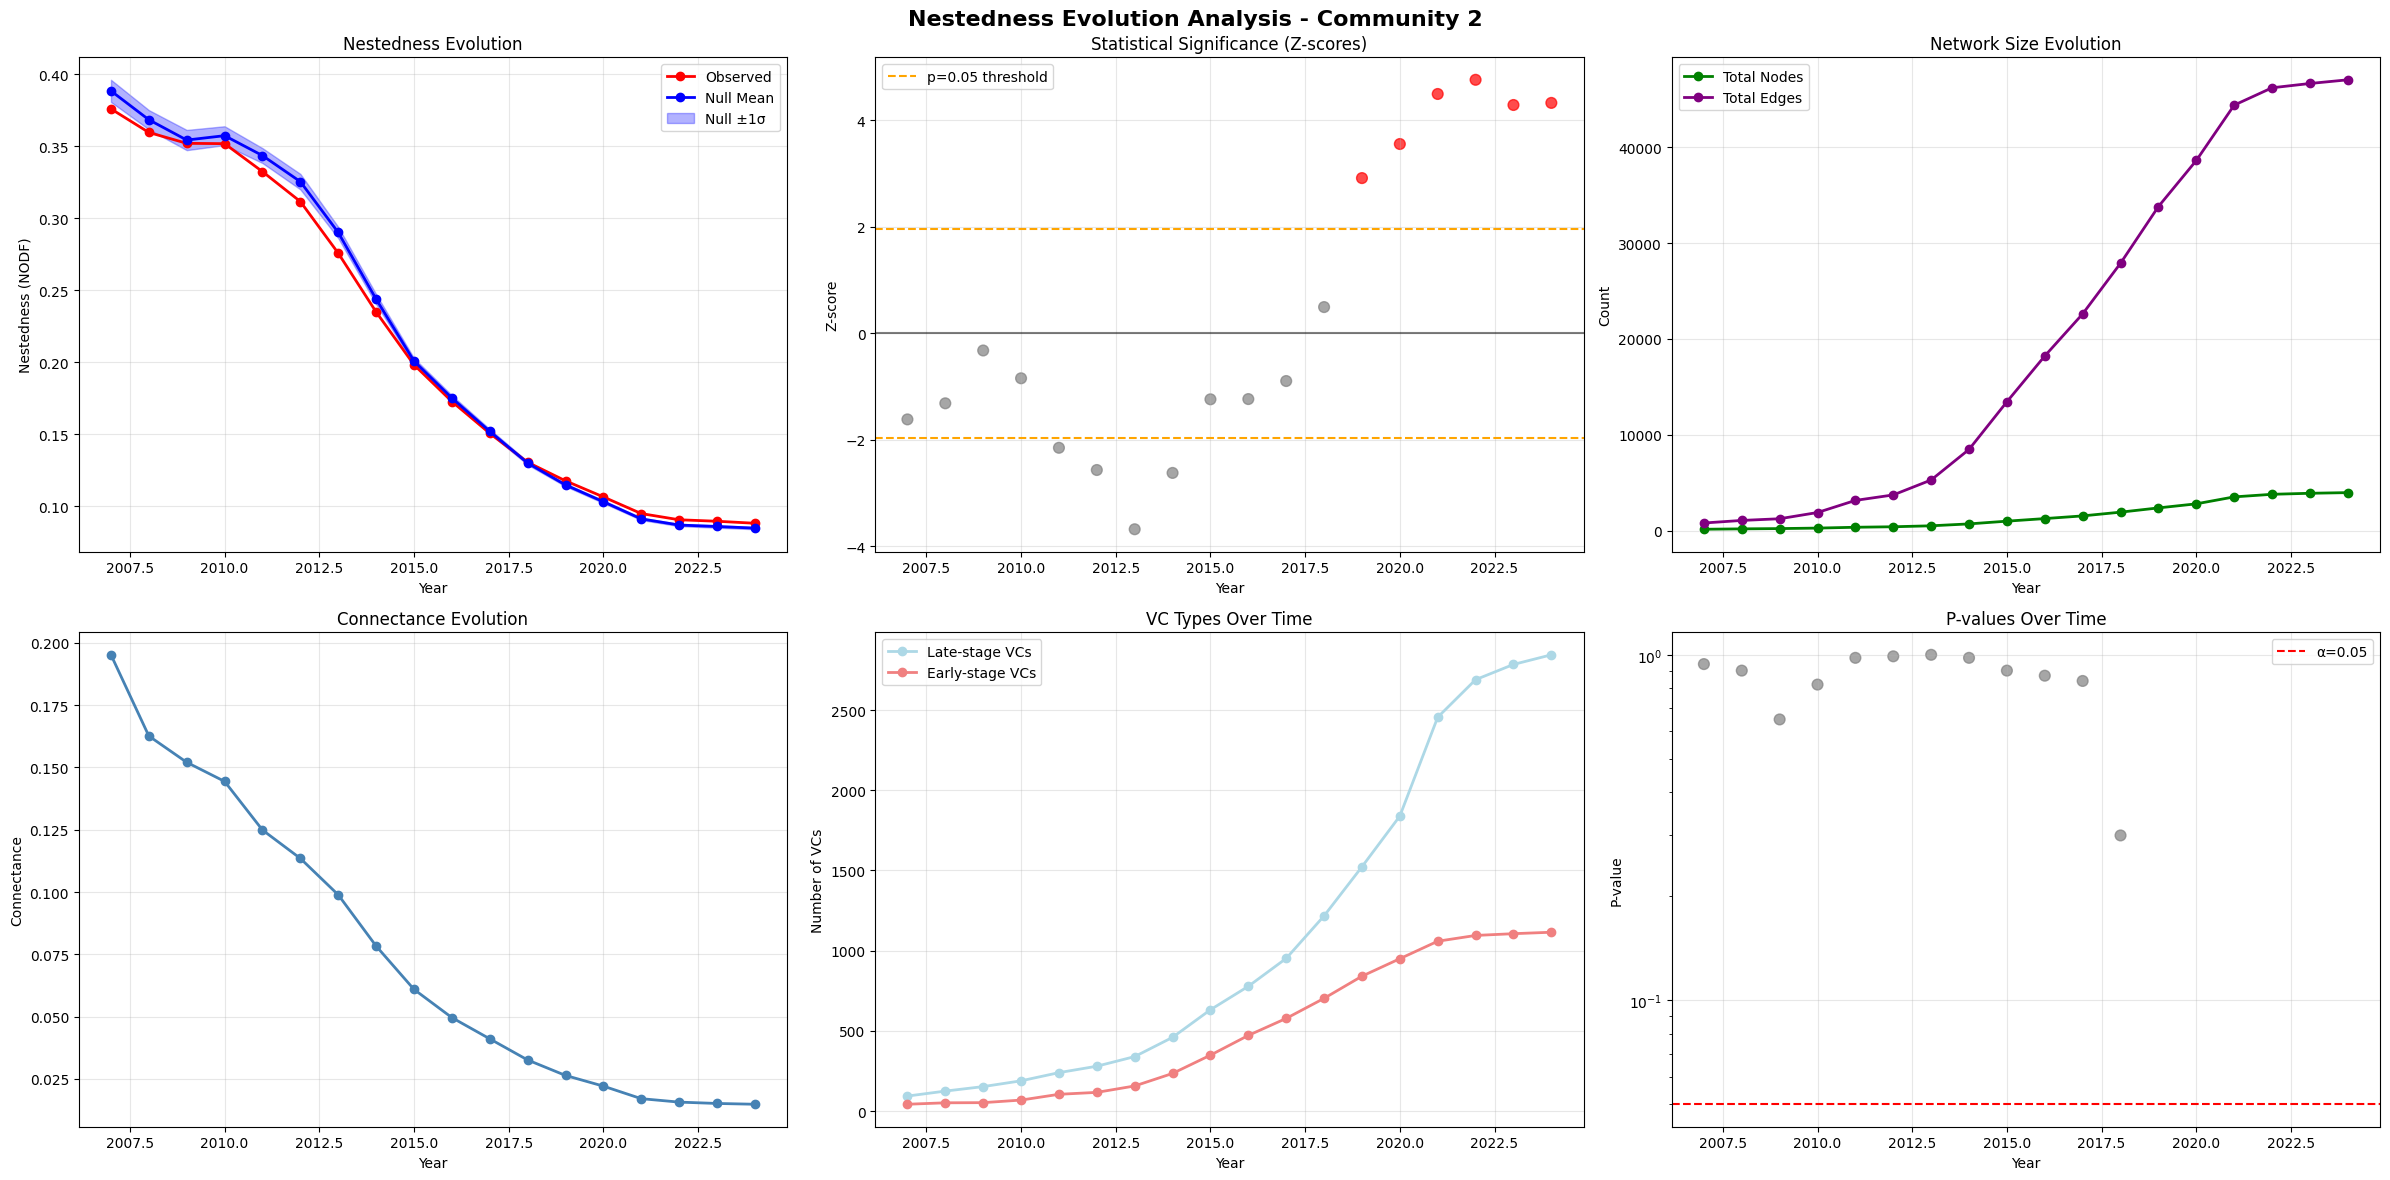

In [83]:
# Create comprehensive visualization of nestedness evolution
if len(community_2_nestedness_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    fig.suptitle(f'Nestedness Evolution Analysis - Community {target_community}', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Observed vs Null Nestedness over time
    ax = axes[0, 0]
    ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['observed_nestedness'], 
            'o-', linewidth=2, markersize=6, color='red', label='Observed')
    ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['null_mean'], 
            'o-', linewidth=2, markersize=6, color='blue', label='Null Mean')
    ax.fill_between(community_2_nestedness_df['year'], 
                   community_2_nestedness_df['null_mean'] - community_2_nestedness_df['null_std'],
                   community_2_nestedness_df['null_mean'] + community_2_nestedness_df['null_std'],
                   alpha=0.3, color='blue', label='Null ±1σ')
    ax.set_title('Nestedness Evolution')
    ax.set_xlabel('Year')
    ax.set_ylabel('Nestedness (NODF)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Z-scores over time
    ax = axes[0, 1]
    colors_sig = ['red' if sig == 'significant' else 'gray' for sig in community_2_nestedness_df['significance']]
    ax.scatter(community_2_nestedness_df['year'], community_2_nestedness_df['z_score'], 
              c=colors_sig, s=60, alpha=0.7)
    ax.axhline(y=1.96, color='orange', linestyle='--', label='p=0.05 threshold')
    ax.axhline(y=-1.96, color='orange', linestyle='--')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax.set_title('Statistical Significance (Z-scores)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Z-score')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Network size evolution
    ax = axes[0, 2]
    ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['num_nodes'], 
            'o-', linewidth=2, markersize=6, color='green', label='Total Nodes')
    ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['num_edges'], 
            'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    ax.set_title('Network Size Evolution')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Connectance evolution
    ax = axes[1, 0]
    ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['connectance'], 
            'o-', linewidth=2, markersize=6, color='steelblue')
    ax.set_title('Connectance Evolution')
    ax.set_xlabel('Year')
    ax.set_ylabel('Connectance')
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Left vs Right VCs
    ax = axes[1, 1]
    ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['num_left_vcs'], 
            'o-', linewidth=2, markersize=6, color='lightblue', label='Late-stage VCs')
    ax.plot(community_2_nestedness_df['year'], community_2_nestedness_df['num_right_vcs'], 
            'o-', linewidth=2, markersize=6, color='lightcoral', label='Early-stage VCs')
    ax.set_title('VC Types Over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of VCs')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 6: P-values over time
    ax = axes[1, 2]
    ax.scatter(community_2_nestedness_df['year'], community_2_nestedness_df['p_value'], 
              c=colors_sig, s=60, alpha=0.7)
    ax.axhline(y=0.05, color='red', linestyle='--', label='α=0.05')
    ax.set_title('P-values Over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('P-value')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization")


Detailed Analysis of Significant Periods for Community 2:

Year 2019 (Window: 1998-2019):
  Investment pairs: 24228
  Network: 1523 late-stage VCs, 841 early-stage VCs
  Edges: 33805, Connectance: 0.0264
  Observed nestedness: 0.1177
  Null mean ± std: 0.1148 ± 0.0010
  Z-score: 2.9125, P-value: 0.000000

Year 2020 (Window: 1999-2020):
  Investment pairs: 31727
  Network: 1839 late-stage VCs, 950 early-stage VCs
  Edges: 38612, Connectance: 0.0221
  Observed nestedness: 0.1065
  Null mean ± std: 0.1031 ± 0.0009
  Z-score: 3.5526, P-value: 0.000000

Year 2021 (Window: 2000-2021):
  Investment pairs: 46340
  Network: 2455 late-stage VCs, 1059 early-stage VCs
  Edges: 44387, Connectance: 0.0171
  Observed nestedness: 0.0949
  Null mean ± std: 0.0912 ± 0.0008
  Z-score: 4.4923, P-value: 0.000000

Year 2022 (Window: 2001-2022):
  Investment pairs: 52374
  Network: 2689 late-stage VCs, 1095 early-stage VCs
  Edges: 46199, Connectance: 0.0157
  Observed nestedness: 0.0906
  Null mean ± std: 

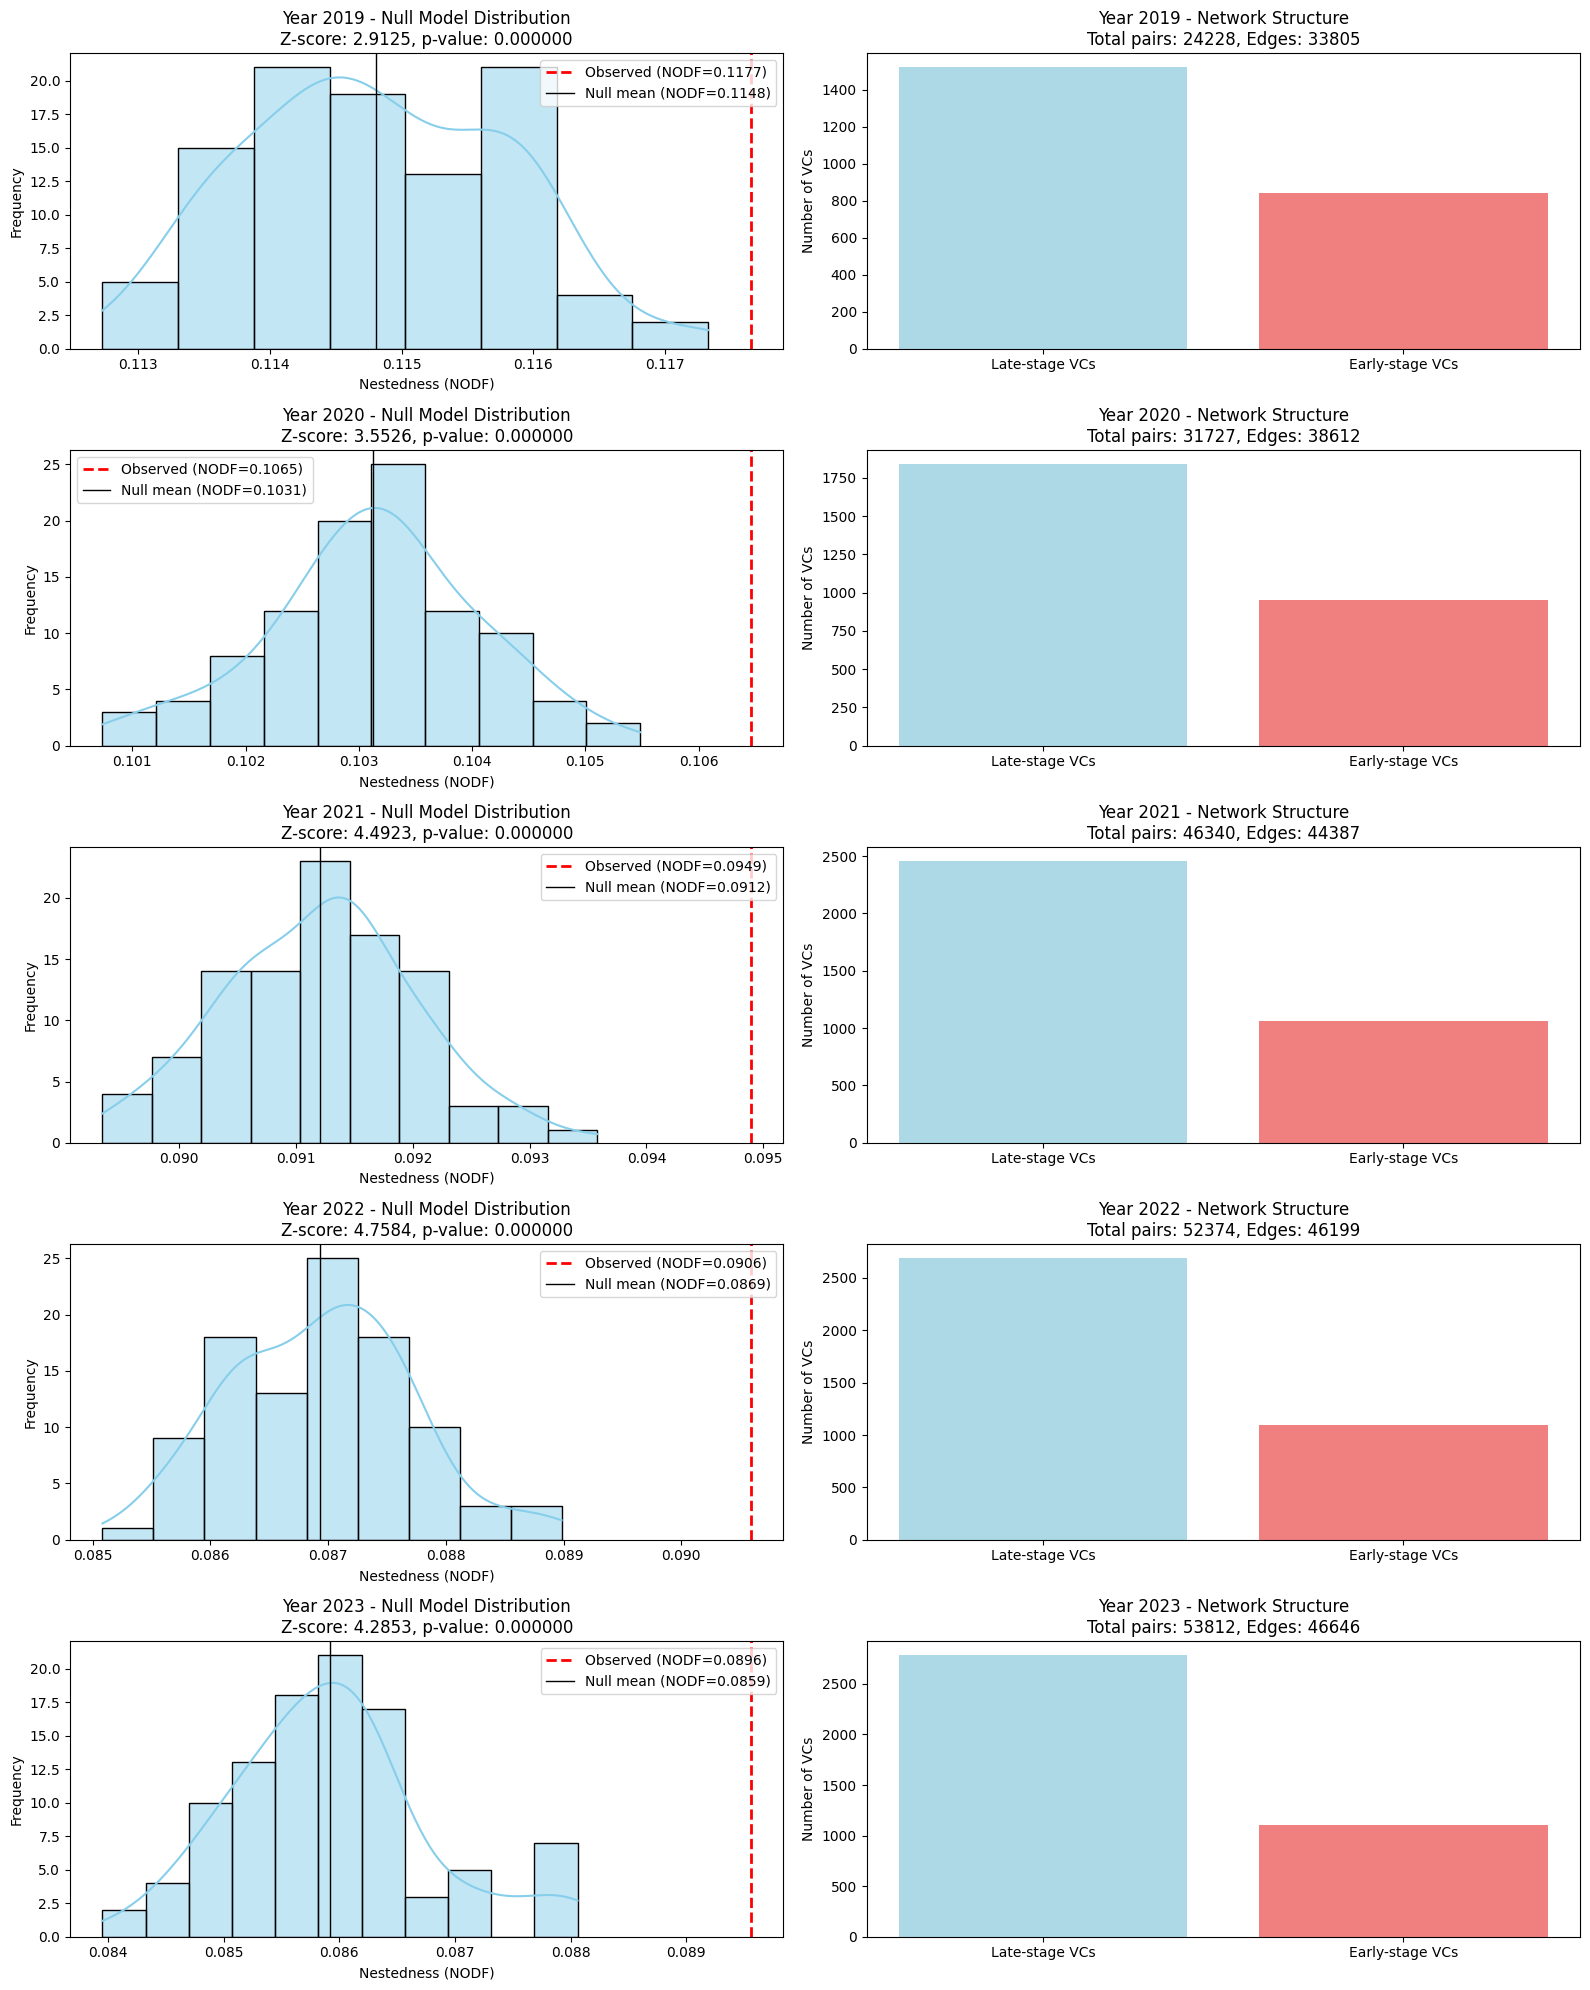

In [84]:
# Detailed analysis of significant periods
if len(community_2_nestedness_df) > 0:
    significant_periods = community_2_nestedness_df[community_2_nestedness_df['significance'] == 'significant']
    
    if len(significant_periods) > 0:
        print(f"\nDetailed Analysis of Significant Periods for Community {target_community}:")
        print("=" * 70)
        
        # Create detailed plots for significant periods
        n_significant = min(len(significant_periods), 5)  # Show up to 5 most significant
        significant_periods_sorted = significant_periods.nsmallest(n_significant, 'p_value')
        
        fig, axes = plt.subplots(n_significant, 2, figsize=(16, 4*n_significant))
        if n_significant == 1:
            axes = axes.reshape(1, -1)
        
        for i, (_, row) in enumerate(significant_periods_sorted.iterrows()):
            year = row['year']
            null_scores = row['null_scores']
            
            print(f"\nYear {year} (Window: {row['window_start']}-{row['window_end']}):")
            print(f"  Investment pairs: {row['num_pairs']}")
            print(f"  Network: {row['num_left_vcs']} late-stage VCs, {row['num_right_vcs']} early-stage VCs")
            print(f"  Edges: {row['num_edges']}, Connectance: {row['connectance']:.4f}")
            print(f"  Observed nestedness: {row['observed_nestedness']:.4f}")
            print(f"  Null mean ± std: {row['null_mean']:.4f} ± {row['null_std']:.4f}")
            print(f"  Z-score: {row['z_score']:.4f}, P-value: {row['p_value']:.6f}")
            
            if len(null_scores) > 0:
                # Plot 1: Null model distribution
                sns.histplot(null_scores, kde=True, color='skyblue', ax=axes[i, 0])
                axes[i, 0].axvline(row['observed_nestedness'], color='red', linestyle='--', 
                                  linewidth=2, label=f'Observed (NODF={row["observed_nestedness"]:.4f})')
                axes[i, 0].axvline(row['null_mean'], color='black', linestyle='-', 
                                  linewidth=1, label=f'Null mean (NODF={row["null_mean"]:.4f})')
                axes[i, 0].set_title(f'Year {year} - Null Model Distribution\n'
                                    f'Z-score: {row["z_score"]:.4f}, p-value: {row["p_value"]:.6f}')
                axes[i, 0].set_xlabel('Nestedness (NODF)')
                axes[i, 0].set_ylabel('Frequency')
                axes[i, 0].legend()
            
            # Plot 2: Network structure
            axes[i, 1].bar(['Late-stage VCs', 'Early-stage VCs'], 
                          [row['num_left_vcs'], row['num_right_vcs']], 
                          color=['lightblue', 'lightcoral'])
            axes[i, 1].set_title(f'Year {year} - Network Structure\n'
                                f'Total pairs: {row["num_pairs"]}, Edges: {row["num_edges"]}')
            axes[i, 1].set_ylabel('Number of VCs')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nNo statistically significant periods found for Community {target_community}")
        print("This suggests that the observed nestedness is not significantly different")
        print("from what would be expected by chance given the degree sequence.")


Temporal Trends Analysis for Community 2:

Year-over-Year Changes (average):
observed_nestedness: -0.0169 per year (total: -0.2879)
connectance: -0.0106 per year (total: -0.1804)
num_nodes: +224.8235 per year (total: +3822.0000)
num_edges: +2720.1176 per year (total: +46242.0000)
z_score: +0.3497 per year (total: +5.9442)

Correlations between metrics and time:
observed_nestedness: r=-0.975 (decreasing trend)
connectance: r=-0.965 (decreasing trend)
z_score: r=0.818 (increasing trend)


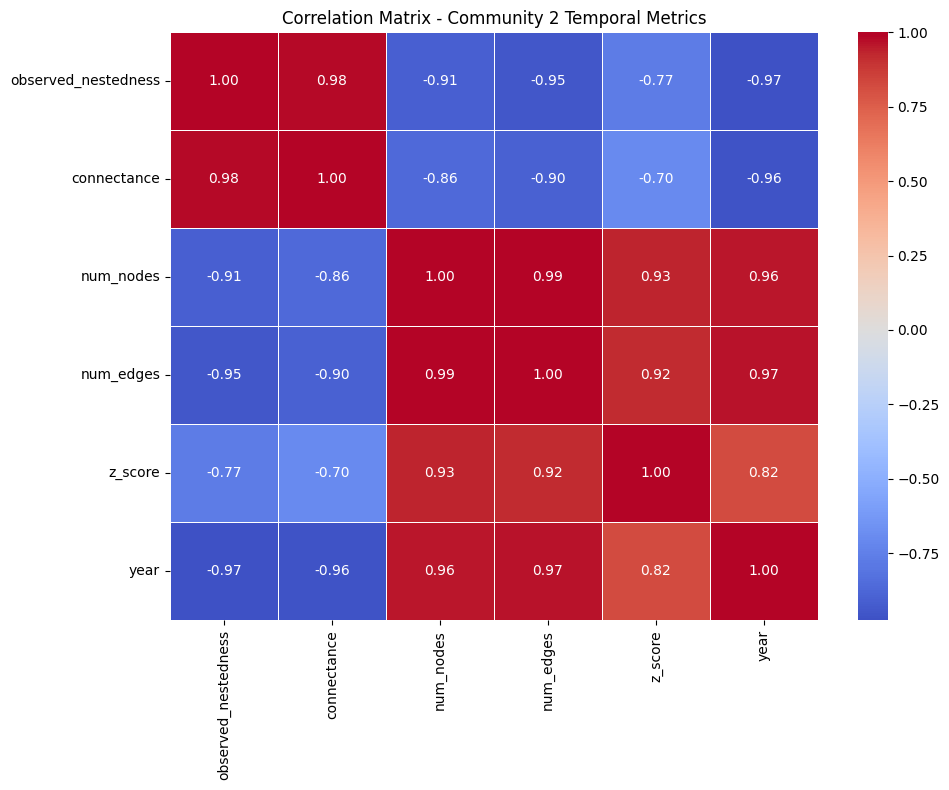


Statistical Tests for Temporal Trends:
Nestedness vs Time - Pearson: r=-0.9749, p=0.0000
Nestedness vs Time - Spearman: r=-1.0000, p=0.0000
Significant decreasing trend in nestedness over time!


In [85]:
# Calculate trends and correlations for community 2
if len(community_2_nestedness_df) > 1:
    print(f"\nTemporal Trends Analysis for Community {target_community}:")
    print("=" * 60)
    
    # Calculate year-over-year changes
    df_sorted = community_2_nestedness_df.sort_values('year')
    
    metrics_to_analyze = ['observed_nestedness', 'connectance', 'num_nodes', 'num_edges', 'z_score']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in df_sorted.columns:
            # Calculate differences
            diffs = df_sorted[metric].diff().dropna()
            if len(diffs) > 0:
                avg_change = diffs.mean()
                total_change = df_sorted[metric].iloc[-1] - df_sorted[metric].iloc[0]
                print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['observed_nestedness', 'connectance', 'z_score']:
        if metric in df_sorted.columns:
            correlation = df_sorted['year'].corr(df_sorted[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
    
    # Create correlation heatmap
    correlation_matrix = df_sorted[metrics_to_analyze + ['year']].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", 
                linewidths=0.5, center=0)
    plt.title(f"Correlation Matrix - Community {target_community} Temporal Metrics")
    plt.tight_layout()
    plt.show()
    
    # Statistical test for temporal trend in nestedness
    from scipy.stats import pearsonr, spearmanr
    
    print("\nStatistical Tests for Temporal Trends:")
    pearson_r, pearson_p = pearsonr(df_sorted['year'], df_sorted['observed_nestedness'])
    spearman_r, spearman_p = spearmanr(df_sorted['year'], df_sorted['observed_nestedness'])
    
    print(f"Nestedness vs Time - Pearson: r={pearson_r:.4f}, p={pearson_p:.4f}")
    print(f"Nestedness vs Time - Spearman: r={spearman_r:.4f}, p={spearman_p:.4f}")
    
    if pearson_p < 0.05:
        trend_desc = "increasing" if pearson_r > 0 else "decreasing"
        print(f"Significant {trend_desc} trend in nestedness over time!")
    else:
        print("No significant temporal trend in nestedness detected.")
else:
    print(f"Insufficient data for temporal trends analysis (need at least 2 years)")